# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re
from ydata_profiling import ProfileReport
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE
import phik
import pickle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

random.seed(42)
np.random.seed(42)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Ответ: Сиды в домашках фиксирутся для того, чтобы можно было воспроизводить результаты благодаря исключению фактора рандома.

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

[x] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)


In [3]:
df_train.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64

In [4]:
print('колонки с пропущенными значениями:\n')
for key, val in dict(df_train.isna().sum()).items():
    if val > 0:
        print(key)

колонки с пропущенными значениями:

mileage
engine
max_power
torque
seats


[x] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)


In [5]:
# явные дубликаты есть!
df_train.duplicated(subset=df_train.columns, keep=False).sum()

np.int64(1478)

In [6]:
# вот явные дубликаты:
df_duplicated = df_train[df_train.duplicated(keep=False)].sort_values(by=['km_driven', 'name'])
df_duplicated.head(10)

name  year  selling_price  km_driven    fuel  \
6401       Maruti Swift LXI  2020         445000       1000  Petrol   
6537       Maruti Swift LXI  2020         445000       1000  Petrol   
116    Honda Amaze S i-VTEC  2019         690000       1303  Petrol   
1594   Honda Amaze S i-VTEC  2019         690000       1303  Petrol   
2786   Honda Amaze S i-VTEC  2019         690000       1303  Petrol   
4484   Honda Amaze S i-VTEC  2019         690000       1303  Petrol   
1982      Honda Jazz VX CVT  2019         840000       1500  Petrol   
6310      Honda Jazz VX CVT  2019         840000       1500  Petrol   
339   Volvo V40 D3 R-Design  2018        2475000       2000  Diesel   
374   Volvo V40 D3 R-Design  2018        2475000       2000  Diesel   

     seller_type transmission        owner     mileage   engine  max_power  \
6401  Individual       Manual  First Owner  21.21 kmpl  1197 CC  81.80 bhp   
6537  Individual       Manual  First Owner  21.21 kmpl  1197 CC  81.80 bhp   
116       Dealer       Manual  First Owner   17.8 kmpl  1198 CC   86.7 bhp   
1594      Dealer       Manual  First Owner   17.8 kmpl  1198 CC   86.7 bhp   
2786      Dealer       Manual  First Owner   17.8 kmpl  1198 CC   86.7 bhp   
4484      Dealer       Manual  First Owner   17.8 kmpl  1198 CC   86.7 bhp   
1982  Individual    Automatic  First Owner   18.2 kmpl  1199 CC   88.7 bhp   
6310  Individual    Automatic  First Owner   18.2 kmpl  1199 CC   88.7 bhp   
339       Dealer    Automatic  First Owner   16.8 kmpl  1984 CC    150 bhp   
374       Dealer    Automatic  First Owner   16.8 kmpl  1984 CC    150 bhp   

                   torque  seats  
6401       113Nm@ 4200rpm    5.0  
6537       113Nm@ 4200rpm    5.0  
116        109Nm@ 4500rpm    5.0  
1594       109Nm@ 4500rpm    5.0  
2786       109Nm@ 4500rpm    5.0  
4484       109Nm@ 4500rpm    5.0  
1982       110Nm@ 4800rpm    5.0  
6310       110Nm@ 4800rpm    5.0  
339   350Nm@ 1500-2750rpm    5.0  
374   350Nm@ 1500-2750rpm    5.0

[x] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)

In [7]:
profile = ProfileReport(df_train, title="Pandas Profiling Report")

In [8]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 131.89it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

[x] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

- Из дашборда в первую очередь видно, между какими признаками есть корреляция:

        Мы видим, что между годом выпуска и пробегом есть сильная корреляция. Также год выпуска сильно влияет на цену при продаже (наш таргет).
        Трансмиссия также влияет на цену при продаже, и это неободимо учитывать.
- Проанализируем статистические покзатели отдельных числовых признаков:

        Распределение целевой переменной selling_price довольно сильно смещено вправо (хвост находится справа). Об этом нам говорит гистограмма, а также сильное различие 95 процентиля (1925000) и максимума (10000000). Также мы видим, что коэффициент вариации составляет 1.26 для этого признака (0.5 считается маленькой вариацией, а 1 - умеренной). То есть вариация здесь очень большая и распределение в целом не сбалансировано.

        Похожую картину мы видим и для пробега (km_driven). Сильное смещение вправо. Огромные показатели kurtosis (410) и skewness (12), что говорит нам об аномальных выбросах, с которыми необходимо что-то сделать.

        Распределение года выпуска наоборот немного смещено влево. То есть на аукционе в основном представлены автомобили 2010х годов, а не 1980х (хотя и такие примеры есть, но это скорее исключение). Тем не менее, мы можем заметить довольно большую разницу между 5 перцентилем и минимальным значением, поэтому стоит обратить внимание на это и возможно удвлить датасета слишком старые машины (как аномалии).

- Категориальные признаки:

        В основном все автомобили по типу топлива делятся на дизельные и бензиновые. Но также есть газовое топливо (CPG, LPG), которое встречается достаточно редко. Надо учитывать, что расход (mileage) указывается по-разному для таких автомобилей, поэтому при обработке этого признака надо учитывать данную особенность. Этот признак можно разбить на 3 категории (или 4, если считать LPG и CPG чем-то принципиально отличающимся).

        В признаке seller_type наблюдается довольно сильный дизбаланс классов. В основном, представленные машины выставлены индивидуальным продавцом (83%), однако есть и машины, выставленные диллером. Этот признак может в теории влиять на конечную цену автомобиля.

        Transmission тоже довольно сильно несбалансирована и при этом сильно влияет на selling_price. При этом большинство автомобилей (87%) оснащены механической КПП.

        Признак того, какой по счету владелец продает эту машину можно разбить на 4-5 категорий. Тут тоже наблюдается довольно сильное преобладание одного класса (first owner).

- Текстовые признаки:

        Почти все текстовые признаки, кроме наименования автомобиля можно разделить на категориальные или числовые признаки (а иногда сразу и на то, и на то).

        Например, из mileage можно выделить числовые признаки просто убрав kmpl для дизеля и бензина и km/kg для газа. Однако надо эксплицитно будет указать, что они не соразмерны. Возможно, нужно будет привести все km/kg к kmpl по какой-нибудь формуле или просто создать отдельный признак для этого.

        Рабочие объемы двигателей все записаны по одному принципу и их спокойно можно привести в численный формат. То же самое с мощностью двигателя.

        Обработка крутящего момента немного сложнее, но из этого признака тоже следует выделить числовые значения.


- Также стоит сказать, что есть пропущенные значения и дубликаты. Полные дубликаты стоит полностью удалить из датасета, а пропущенные значения можно будет заменить медианным или средним значением (или тоже удалить).
        

In [9]:
for i in range(0, len(df_train)):
  try:
    ffil_value = float(df_train.loc[i, 'max_power'][:-4])
    df_train.loc[i, 'max_power'] = ffil_value

  except:
    if df_train.loc[i, 'max_power'] in [np.nan, 'nan']:
      continue
    elif df_train.loc[i, 'max_power'] == '0':
      ffil_value = float(df_train.loc[i, 'max_power'])
      df_train.loc[i, 'max_power'] = ffil_value
    else:
      df_train.loc[i, 'max_power'] = 0


### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

[x] Посчитайте основные статистики по числовым столбцам для трейна и теста

In [10]:
df_train.describe(include='number')

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [11]:
df_test.describe(include='number')

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

[x] Посчитайте основные статистики по категориальным столбцам для трейна и теста

In [12]:
df_train[['fuel', 'seller_type', 'transmission', 'owner']].describe()

fuel seller_type transmission        owner
count     6999        6999         6999         6999
unique       4           3            2            5
top     Diesel  Individual       Manual  First Owner
freq      3793        5826         6095         4587

In [13]:
df_test[['fuel', 'seller_type', 'transmission', 'owner']].describe()

fuel seller_type transmission        owner
count     1000        1000         1000         1000
unique       4           3            2            5
top     Diesel  Individual       Manual  First Owner
freq       534         837          877          623

[x] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?


In [14]:
df_train.describe(include='number').loc[['mean', '50%']]

year  selling_price     km_driven     seats
mean  2013.818403  639515.197171  69584.615517  5.419008
50%   2015.000000  450000.000000  60000.000000  5.000000

In [15]:
df_test.describe(include='number').loc[['mean', '50%']]

year  selling_price  km_driven     seats
mean  2013.681     617901.042  71393.341  5.410805
50%   2014.000     434999.000  61500.000  5.000000

В общем случае, если медиана больше среднего, то распределение смещено влево, а если медиана меньше среднего - то вправо.

Рассмотрим признаки, для которых характерно смещение вправо:
- selling_price
- km_driven
- seats

причем это справедливо для train и test датасетов, поэтому можно предположить что выбросы есть в обоих датасетах

Единственный признак, для которого характерно смещение влево - это:
- year

то есть в датасете представлены в основном новые машины

[x] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

- year

        Минимальный год выпуска в трейне - 1983, а в тесте - 1995, однако 25 процентель совпадает, как и 75, поэтому распределение по годам очень близкое. Распределение смещено влево, автомобили 2010х годов, в основном.

- selling_price 

        Распределение по selling_price у трейна и теста также очень похоже. Обоим соответсвтует сильное смещение вправо.

- km_driven

        Распределение этого признака в трейне и тесте не так сильно похоже, как в selling_price. Например, стандартное отклонение у трейна - 57 тыс, а у теста - 48 тыс. При этом процентили у них совпадают. Кроме минимального (1 и 1300) и максимального (2.3 млн и 375 тыс.). То есть по этому признаку разные аномальные покзаатели в трейне и тесте. В целом, это хорошо, что в тесте нет таких сильных выборосов. 

- seats

        Тут так же, как и в km_driven более широкий спектр значений. И при этом полное совпадение процентилей. 

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ] Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

[x] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)

In [16]:
# количество объектов с одинаковым признаковым описанием
len(df_train.drop(columns='selling_price')[df_train.drop(columns='selling_price').duplicated(keep=False)].sort_values(by=['km_driven', 'name']))

1799

[x] Отобразите такие объекты (0.01 балла)

In [17]:
df_train.drop(columns='selling_price')[df_train.drop(columns='selling_price').duplicated(keep=False)].sort_values(by=['km_driven', 'name']).head(10)

name  year  km_driven    fuel seller_type transmission  \
6401       Maruti Swift LXI  2020       1000  Petrol  Individual       Manual   
6537       Maruti Swift LXI  2020       1000  Petrol  Individual       Manual   
116    Honda Amaze S i-VTEC  2019       1303  Petrol      Dealer       Manual   
1594   Honda Amaze S i-VTEC  2019       1303  Petrol      Dealer       Manual   
2786   Honda Amaze S i-VTEC  2019       1303  Petrol      Dealer       Manual   
4484   Honda Amaze S i-VTEC  2019       1303  Petrol      Dealer       Manual   
1982      Honda Jazz VX CVT  2019       1500  Petrol  Individual    Automatic   
6310      Honda Jazz VX CVT  2019       1500  Petrol  Individual    Automatic   
339   Volvo V40 D3 R-Design  2018       2000  Diesel      Dealer    Automatic   
374   Volvo V40 D3 R-Design  2018       2000  Diesel      Dealer    Automatic   

            owner     mileage   engine max_power               torque  seats  
6401  First Owner  21.21 kmpl  1197 CC      81.8       113Nm@ 4200rpm    5.0  
6537  First Owner  21.21 kmpl  1197 CC      81.8       113Nm@ 4200rpm    5.0  
116   First Owner   17.8 kmpl  1198 CC      86.7       109Nm@ 4500rpm    5.0  
1594  First Owner   17.8 kmpl  1198 CC      86.7       109Nm@ 4500rpm    5.0  
2786  First Owner   17.8 kmpl  1198 CC      86.7       109Nm@ 4500rpm    5.0  
4484  First Owner   17.8 kmpl  1198 CC      86.7       109Nm@ 4500rpm    5.0  
1982  First Owner   18.2 kmpl  1199 CC      88.7       110Nm@ 4800rpm    5.0  
6310  First Owner   18.2 kmpl  1199 CC      88.7       110Nm@ 4800rpm    5.0  
339   First Owner   16.8 kmpl  1984 CC     150.0  350Nm@ 1500-2750rpm    5.0  
374   First Owner   16.8 kmpl  1984 CC     150.0  350Nm@ 1500-2750rpm    5.0

[x] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)

In [18]:
df_train = df_train[~df_train.drop(columns='selling_price').duplicated(keep='first')]

[x] Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)

In [19]:
df_train = df_train.reset_index(drop=True)

[x] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

Да, дубли могут быть скрытыми, например в датасет может два раза попасть автомобиль, который сначала был выставлен за 100000 рублей, а потом за 90000. 
Чтобы это отловить можно попытаться искать дубли, не взирая на стоимость (хотя мы уже так и делали).

По такому же принципу может отличаться пробег на несколько километров (допустим, при выявлении скрученного пробега этот показатель изменили).
Попробуем найти такие автомобили, у которых отличается только пробег. 

In [20]:
df_train[df_train.duplicated(subset=[c for c in df_train.columns if c!='km_driven'], keep=False)].sort_values(by=['name', 'km_driven']).head(10)

name  year  selling_price  km_driven  \
3479   BMW 6 Series GT 630d Luxury Line  2018        6000000      27000   
871    BMW 6 Series GT 630d Luxury Line  2018        6000000      28156   
124          BMW X4 M Sport X xDrive20d  2019        5800000       7500   
5331         BMW X4 M Sport X xDrive20d  2019        5800000      21000   
2180                  Chevrolet Beat LT  2011         120000      60000   
3784                  Chevrolet Beat LT  2010         140000      60000   
982                   Chevrolet Beat LT  2010         140000      75000   
2064                  Chevrolet Beat LT  2011         120000      90000   
24    Chevrolet Enjoy TCDi LTZ 7 Seater  2013         300000      70000   
4858  Chevrolet Enjoy TCDi LTZ 7 Seater  2013         300000      90000   

        fuel seller_type transmission        owner     mileage   engine  \
3479  Diesel      Dealer    Automatic  First Owner  17.09 kmpl  2993 CC   
871   Diesel      Dealer    Automatic  First Owner  17.09 kmpl  2993 CC   
124   Diesel      Dealer    Automatic  First Owner  16.78 kmpl  1995 CC   
5331  Diesel      Dealer    Automatic  First Owner  16.78 kmpl  1995 CC   
2180  Petrol  Individual       Manual  First Owner   18.6 kmpl  1199 CC   
3784  Petrol  Individual       Manual  First Owner   18.6 kmpl  1199 CC   
982   Petrol  Individual       Manual  First Owner   18.6 kmpl  1199 CC   
2064  Petrol  Individual       Manual  First Owner   18.6 kmpl  1199 CC   
24    Diesel  Individual       Manual  First Owner   18.2 kmpl  1248 CC   
4858  Diesel  Individual       Manual  First Owner   18.2 kmpl  1248 CC   

     max_power               torque  seats  
3479     261.4  620Nm@ 2000-2500rpm    4.0  
871      261.4  620Nm@ 2000-2500rpm    4.0  
124      190.0  400Nm@ 1750-2500rpm    5.0  
5331     190.0  400Nm@ 1750-2500rpm    5.0  
2180      79.4       108Nm@ 4400rpm    5.0  
3784      79.4       108Nm@ 4400rpm    5.0  
982       79.4       108Nm@ 4400rpm    5.0  
2064      79.4       108Nm@ 4400rpm    5.0  
24        73.8     172.5Nm@ 1750rpm    7.0  
4858      73.8     172.5Nm@ 1750rpm    7.0

Нашлось целых 155 (310 / 2) дубликатов, у которых совпадает все, кроме пробега. Логично удалить такие записи из датасета.

Также может быть разный формат в текстовых данных, например в признаках "name", "torque". Можно обрабатывать эти признаки (например, с помощью регулярных выражений) и потом снова сравнить дубликаты.

In [21]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

[x] Уберите единицы измерения для признаков ``mileage, engine, max_power``.


&

[x] Приведите тип данных к ``float``.

In [22]:
regex_pattern = r"[-+]?([0-9]*\.[0-9]+|\d+)" # регекс с помощью которого мы можем взять все числа из строки

def extract_number(series):
    return series.apply(
        lambda x: float(re.findall(regex_pattern, str(x))[0]) if pd.notnull(x) and re.findall(regex_pattern, str(x)) else np.nan
    )
for col in ['mileage', 'engine', 'max_power']:
    df_train[col] = extract_number(df_train[col])
    df_test[col]  = extract_number(df_test[col])

[x] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения

In [23]:
def extract_rpm(x):
    if pd.isna(x):
        return np.nan
    
    match = re.findall(r"(@|at|/)\s*[^0-9]*(?:[0-9,.]+-)?([0-9,.]*)", str(x), re.IGNORECASE)
    if not match:
        return np.nan
    match = float(str(match[0][1]).replace(',', ''))

    return match

df_train['max_torque_rpm'] = df_train['torque'].apply(extract_rpm)
df_test['max_torque_rpm'] = df_test['torque'].apply(extract_rpm)

In [24]:
def extract_torque(x):
    if pd.isna(x):
        return np.nan
    
    # регекс подобран методом проб и ошибок
    match = re.findall(r"([-+]?(?:\d*\.\d+|\d+))[^a-zA-Z]*(kgm|nm)?", str(x), re.IGNORECASE)[0]
    if not match:
        return np.nan

    unit = match[1].lower() if match[1] else None
    number = float(match[0]) * (1 if unit != 'kgm' else 9.8)

    return number

df_train['torque'] = df_train['torque'].apply(extract_torque)
df_test['torque'] = df_test['torque'].apply(extract_torque)


### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






[x] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.

In [25]:
df_train.isna().sum()

name                0
year                0
selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           186
engine            186
max_power         183
torque            187
seats             186
max_torque_rpm    190
dtype: int64

In [26]:
cols_with_na = [i[0] for i in filter(lambda x: x[1] > 0, dict(df_train.isna().sum()).items())]
for col in cols_with_na:
    train_median = df_train[col].median()
    df_train[col] = df_train[col].fillna(train_median)
    df_test[col] = df_test[col].fillna(train_median)

In [27]:
print(f"Сумма всех NaN в df_train: {sum(df_train.isna().sum())}\nСумма всех NaN в df_test: {sum(df_test.isna().sum())}")

Сумма всех NaN в df_train: 0
Сумма всех NaN в df_test: 0


[x] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.

Иногда можно применять среднее, однако в данном случае медиана покажет себя лучше, поскольку распределение датасетов смещено вправо. То есть среднее будет менее информативным, чем медиана, а также будет больше подвергнуто искажению из-за аномальных записей. Из-за этого даже метрика может стать гораздно хуже в случае использования среднего.

[x] Как правильно считать медиану для заполнения? Выберите верное утверждение:

        По тренировочным данным для `train` и `test`

Правильно считать медиану именно по тренировочным данным, поскольку они ИЗВЕСТНЫ нам в момент обучения модели. 
В отличие от тестовых данных, которых у нас может не быть в момент использования модели.

Допустим, у нас появлятется новая машина для аукциона или чего-то еще, но нам доступна только сама модель и её веса (вычислить медиану по всем автомобилям в таких условиях невозможно). Тогда получится, что наша модель переобучена именно для хорошего результата на ТЕСТЕ, но при этом в реальной ситуации не выдает желаемый результат.

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [28]:
df_train['engine'] = df_train['engine'].apply(int)
df_train['seats'] = df_train['seats'].apply(int)
df_test['engine'] = df_test['engine'].apply(int)
df_test['seats'] = df_test['seats'].apply(int)

seats можно рассматривать как категориальную переменную, потому что уникальных значений всего 9, и по большей части количество сидений определяет некий класс автомобиля, например: 2 сиденья встречается либо в спорткаре, либо просто в кузовах типа "купе"; 4-5 мест в принципе характерно для обычной городской машины (седан, кроссовер, итд); 6 и более сидений могут встречаться в грузовых автомобилях или в длинных кузовах (long версии); 10 и 14 - очень большое количество сидений и характерно для общественного транспорта и т.п.

То есть мы могли бы выделить эти категории (произвольно их определив перед этим) и это дало бы модли больше поинмания значимости признака, чем просто количество сидений.

In [29]:
# уникальные значения seats
df_train['seats'].unique()

array([ 5,  4,  7,  8,  6,  9, 10, 14,  2])

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [x] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [30]:
df_train.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
95%    2019.000000   1.200500e+06  1.560410e+05    25.800000  2499.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.892354   175.347077     5.426712     3044.761644  
std      31.661223   107.112266     0.982344      911.090388  
min       0.000000    47.040000     2.000000     1400.000000  
25%      68.000000   111.800000     5.000000     2250.000000  
50%      81.860000   160.000000     5.000000     3000.000000  
75%      99.000000   200.000000     5.000000     4000.000000  
95%     147.900000   330.000000     7.000000     4500.000000  
max     400.000000  1862.000000    14.000000    21800.000000

Во-первых, у нас появилось больше данных для анализа, т.к. мы создали новые числовые признаки на основе текстовых.

        Мы можем увидеть, что у всех новых числовых признаков есть аномальные значения, которые, например, в несколько раз превышают значения 95 процентиля.

Во-вторых

        Наши изначальные признаки, которые мы анализировали не изменились (за исключением seats). Поэтому, говорить о сдвиге распределения из-за того, что мы заполнили пропуски - это сомнительно. Хотя в теории, если бы мы заполняли медианами пропуски в тех же признаки, что мы анализировали сначала, то это могло бы повлиять на сдвиг распределения, поскольку все средние стали бы ближе к медианному значению (т.к. медианных значений стало бы больше). 

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [x] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [x] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

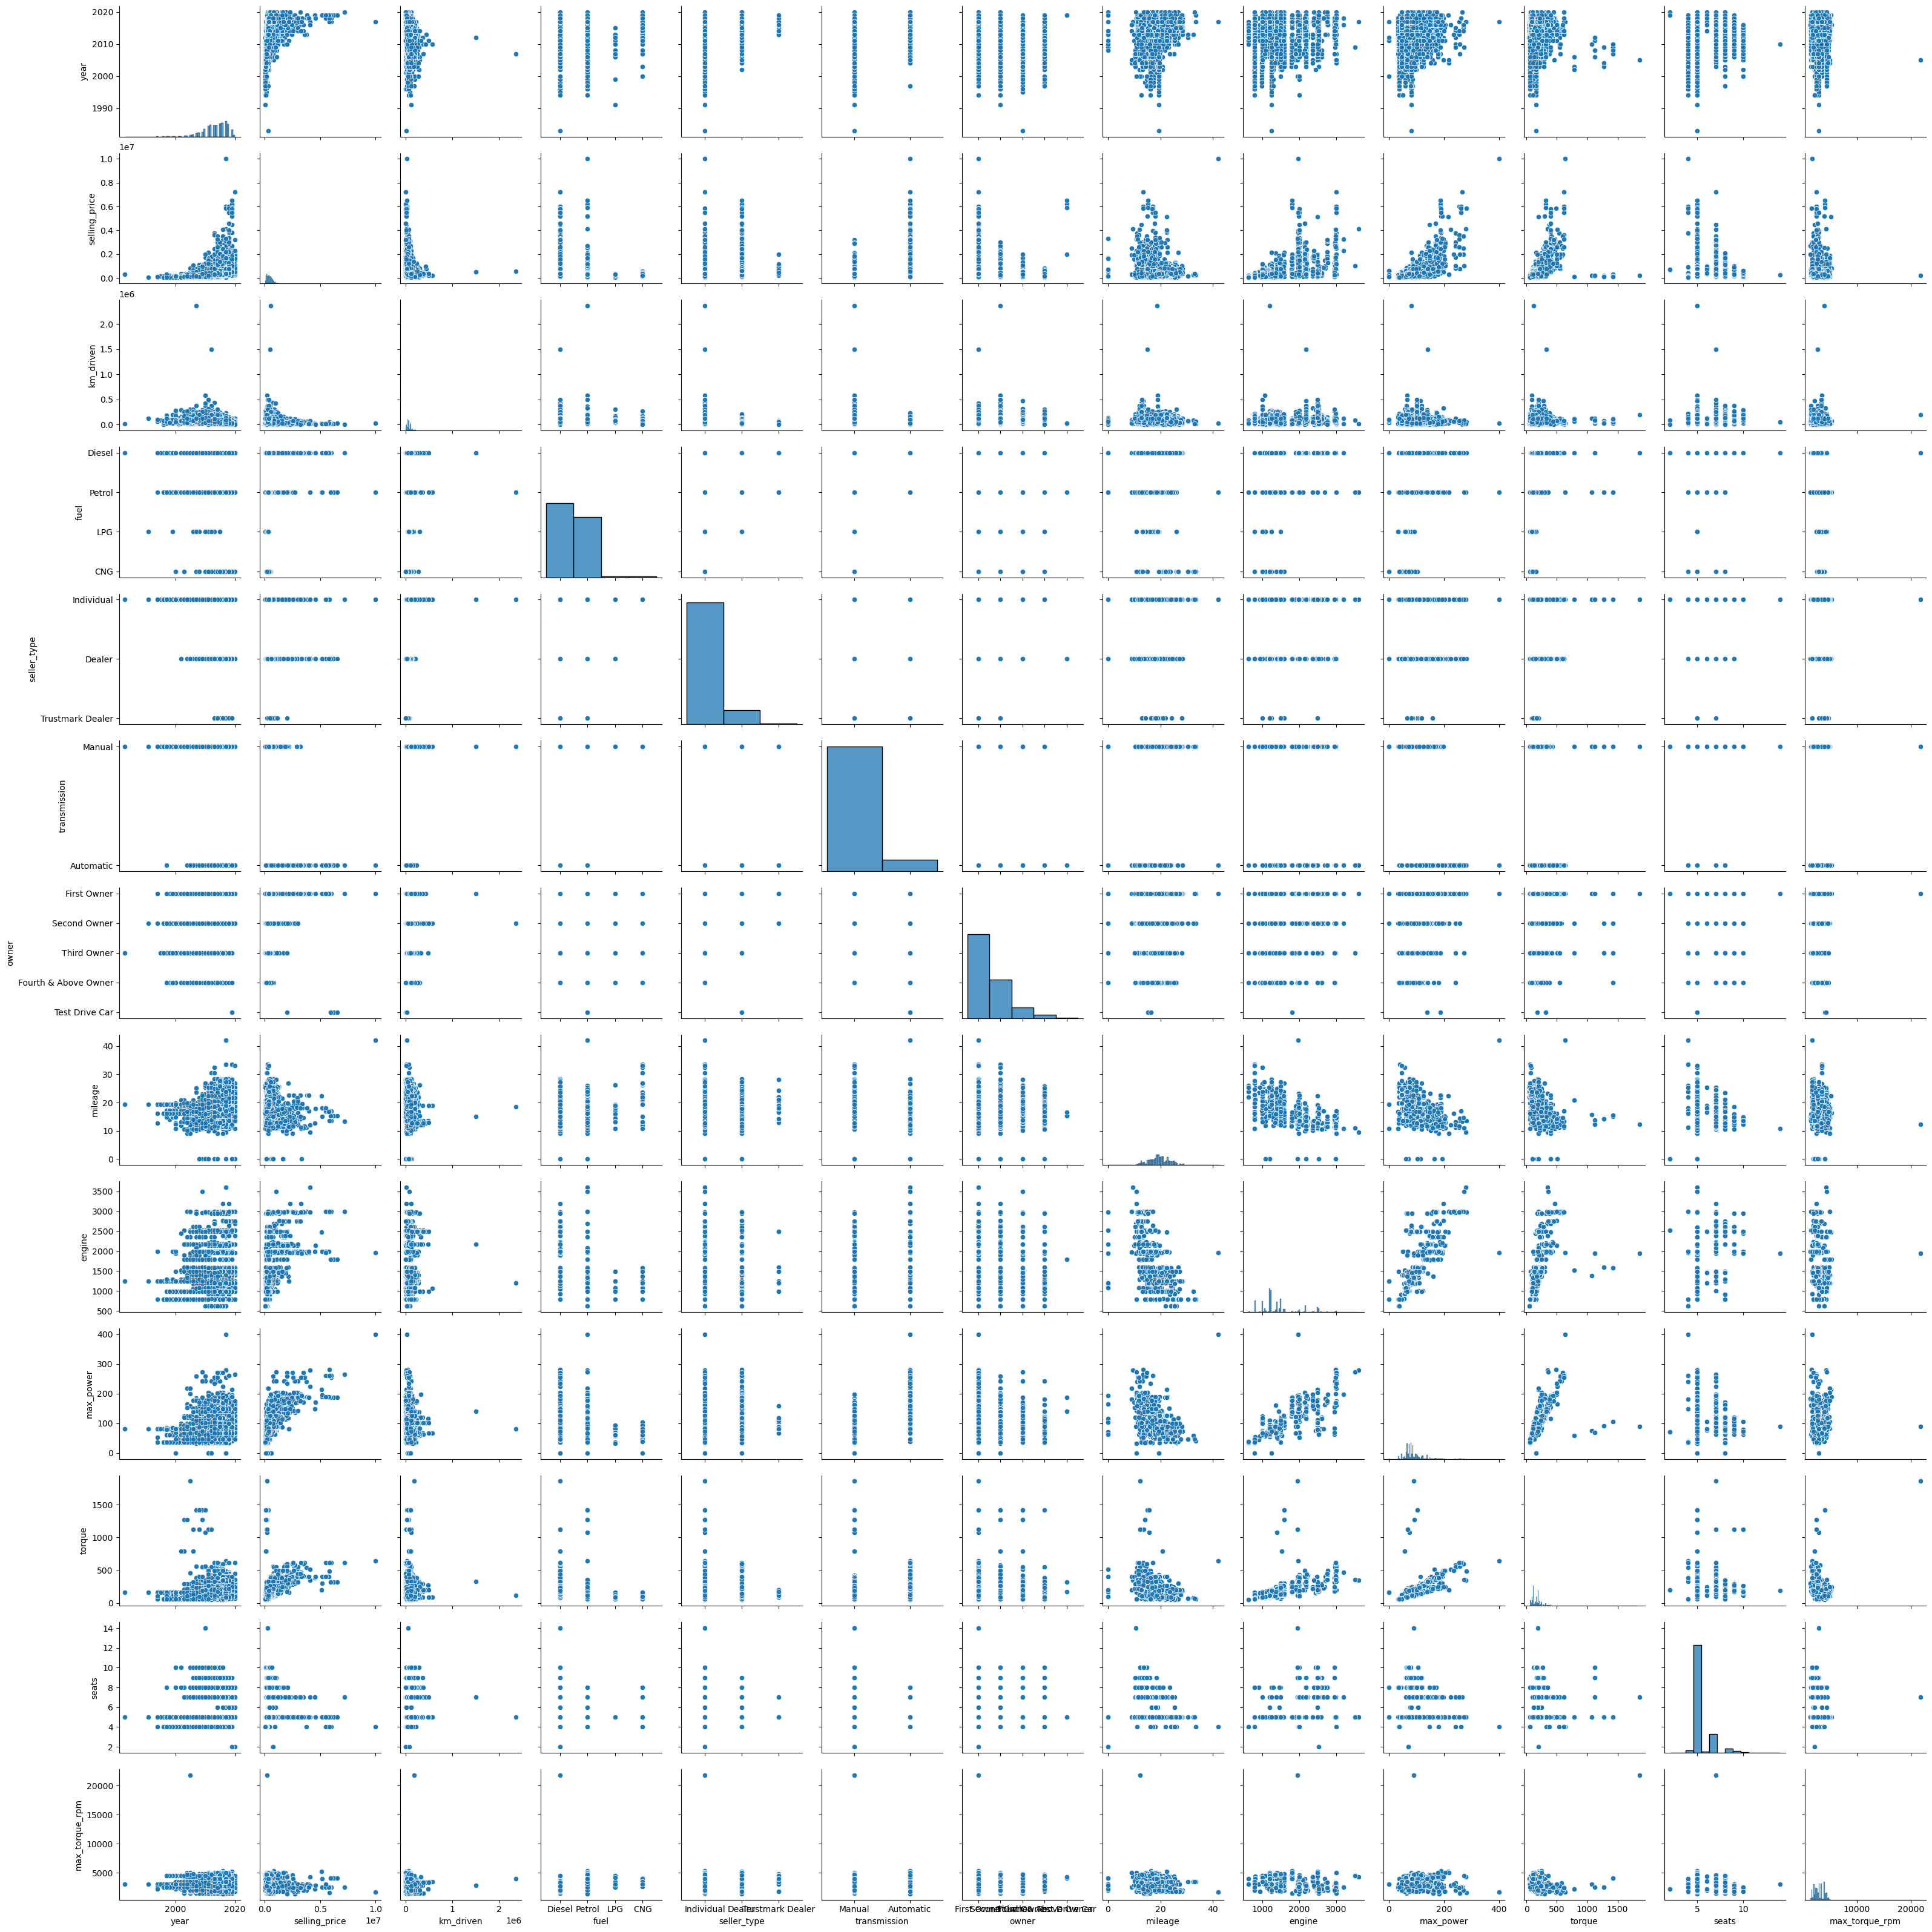

In [31]:
%matplotlib inline

cols = list(df_train.columns)
del cols[0]

sns.pairplot(df_train, x_vars=cols, y_vars=cols)
plt.show()


- Да, на основе данных графиков можно предположить различные корреляции признаков с целевой переменной. Например, мы видим, что year, km_driven, engine, max_power, torque, owner влияют на целевюу переменную selling_price.

- Также можно выдвинуть гипотезу и о корреляции признаков между собой. Очевидна корреляция между engine, max_power, torque - причем иногда корреляция почти линейная, поэтому с этими признаками нужно быть аккуратными.


Шаг 2.

- [x] Постройте pairplot по тестовым данным
- [x] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [32]:
df_test

name  year  selling_price  km_driven  \
0                    Mahindra Xylo E4 BS IV  2010         229999     168000   
1                Tata Nexon 1.5 Revotorq XE  2017         665000      25000   
2                      Honda Civic 1.8 S AT  2007         175000     218463   
3                      Honda City i DTEC VX  2015         635000     173000   
4    Tata Indica Vista Aura 1.2 Safire BSIV  2011         130000      70000   
..                                      ...   ...            ...        ...   
995                  Hyundai i10 Magna 1.1L  2008         250000     100000   
996        Hyundai i20 2015-2017 Sportz 1.2  2017         440000      50000   
997                  Hyundai i20 Era Diesel  2009         340000      40000   
998                        Hyundai i10 Asta  2012         350000      25000   
999                    Honda City i DTec SV  2016         700000     110000   

       fuel seller_type transmission         owner  mileage  engine  \
0    Diesel  Individual       Manual   First Owner    14.00    2498   
1    Diesel  Individual       Manual   First Owner    21.50    1497   
2    Petrol  Individual    Automatic   First Owner    12.90    1799   
3    Diesel  Individual       Manual   First Owner    25.10    1498   
4    Petrol  Individual       Manual  Second Owner    16.50    1172   
..      ...         ...          ...           ...      ...     ...   
995  Petrol  Individual       Manual  Second Owner    19.81    1086   
996  Petrol  Individual       Manual  Second Owner    18.60    1197   
997  Diesel  Individual       Manual   First Owner    23.00    1396   
998  Petrol  Individual       Manual   First Owner    20.36    1197   
999  Diesel  Individual       Manual   First Owner    26.00    1498   

     max_power  torque  seats  max_torque_rpm  
0       112.00  260.00      7          2200.0  
1       108.50  260.00      5          2750.0  
2       130.00  172.00      5          4300.0  
3        98.60  200.00      5          1750.0  
4        65.00   96.00      5          3000.0  
..         ...     ...    ...             ...  
995      68.05   99.04      5          4500.0  
996      81.83  114.70      5          4000.0  
997      90.00  219.52      5          2750.0  
998      78.90  111.80      5          4000.0  
999      98.60  200.00      5          1750.0  

[1000 rows x 14 columns]

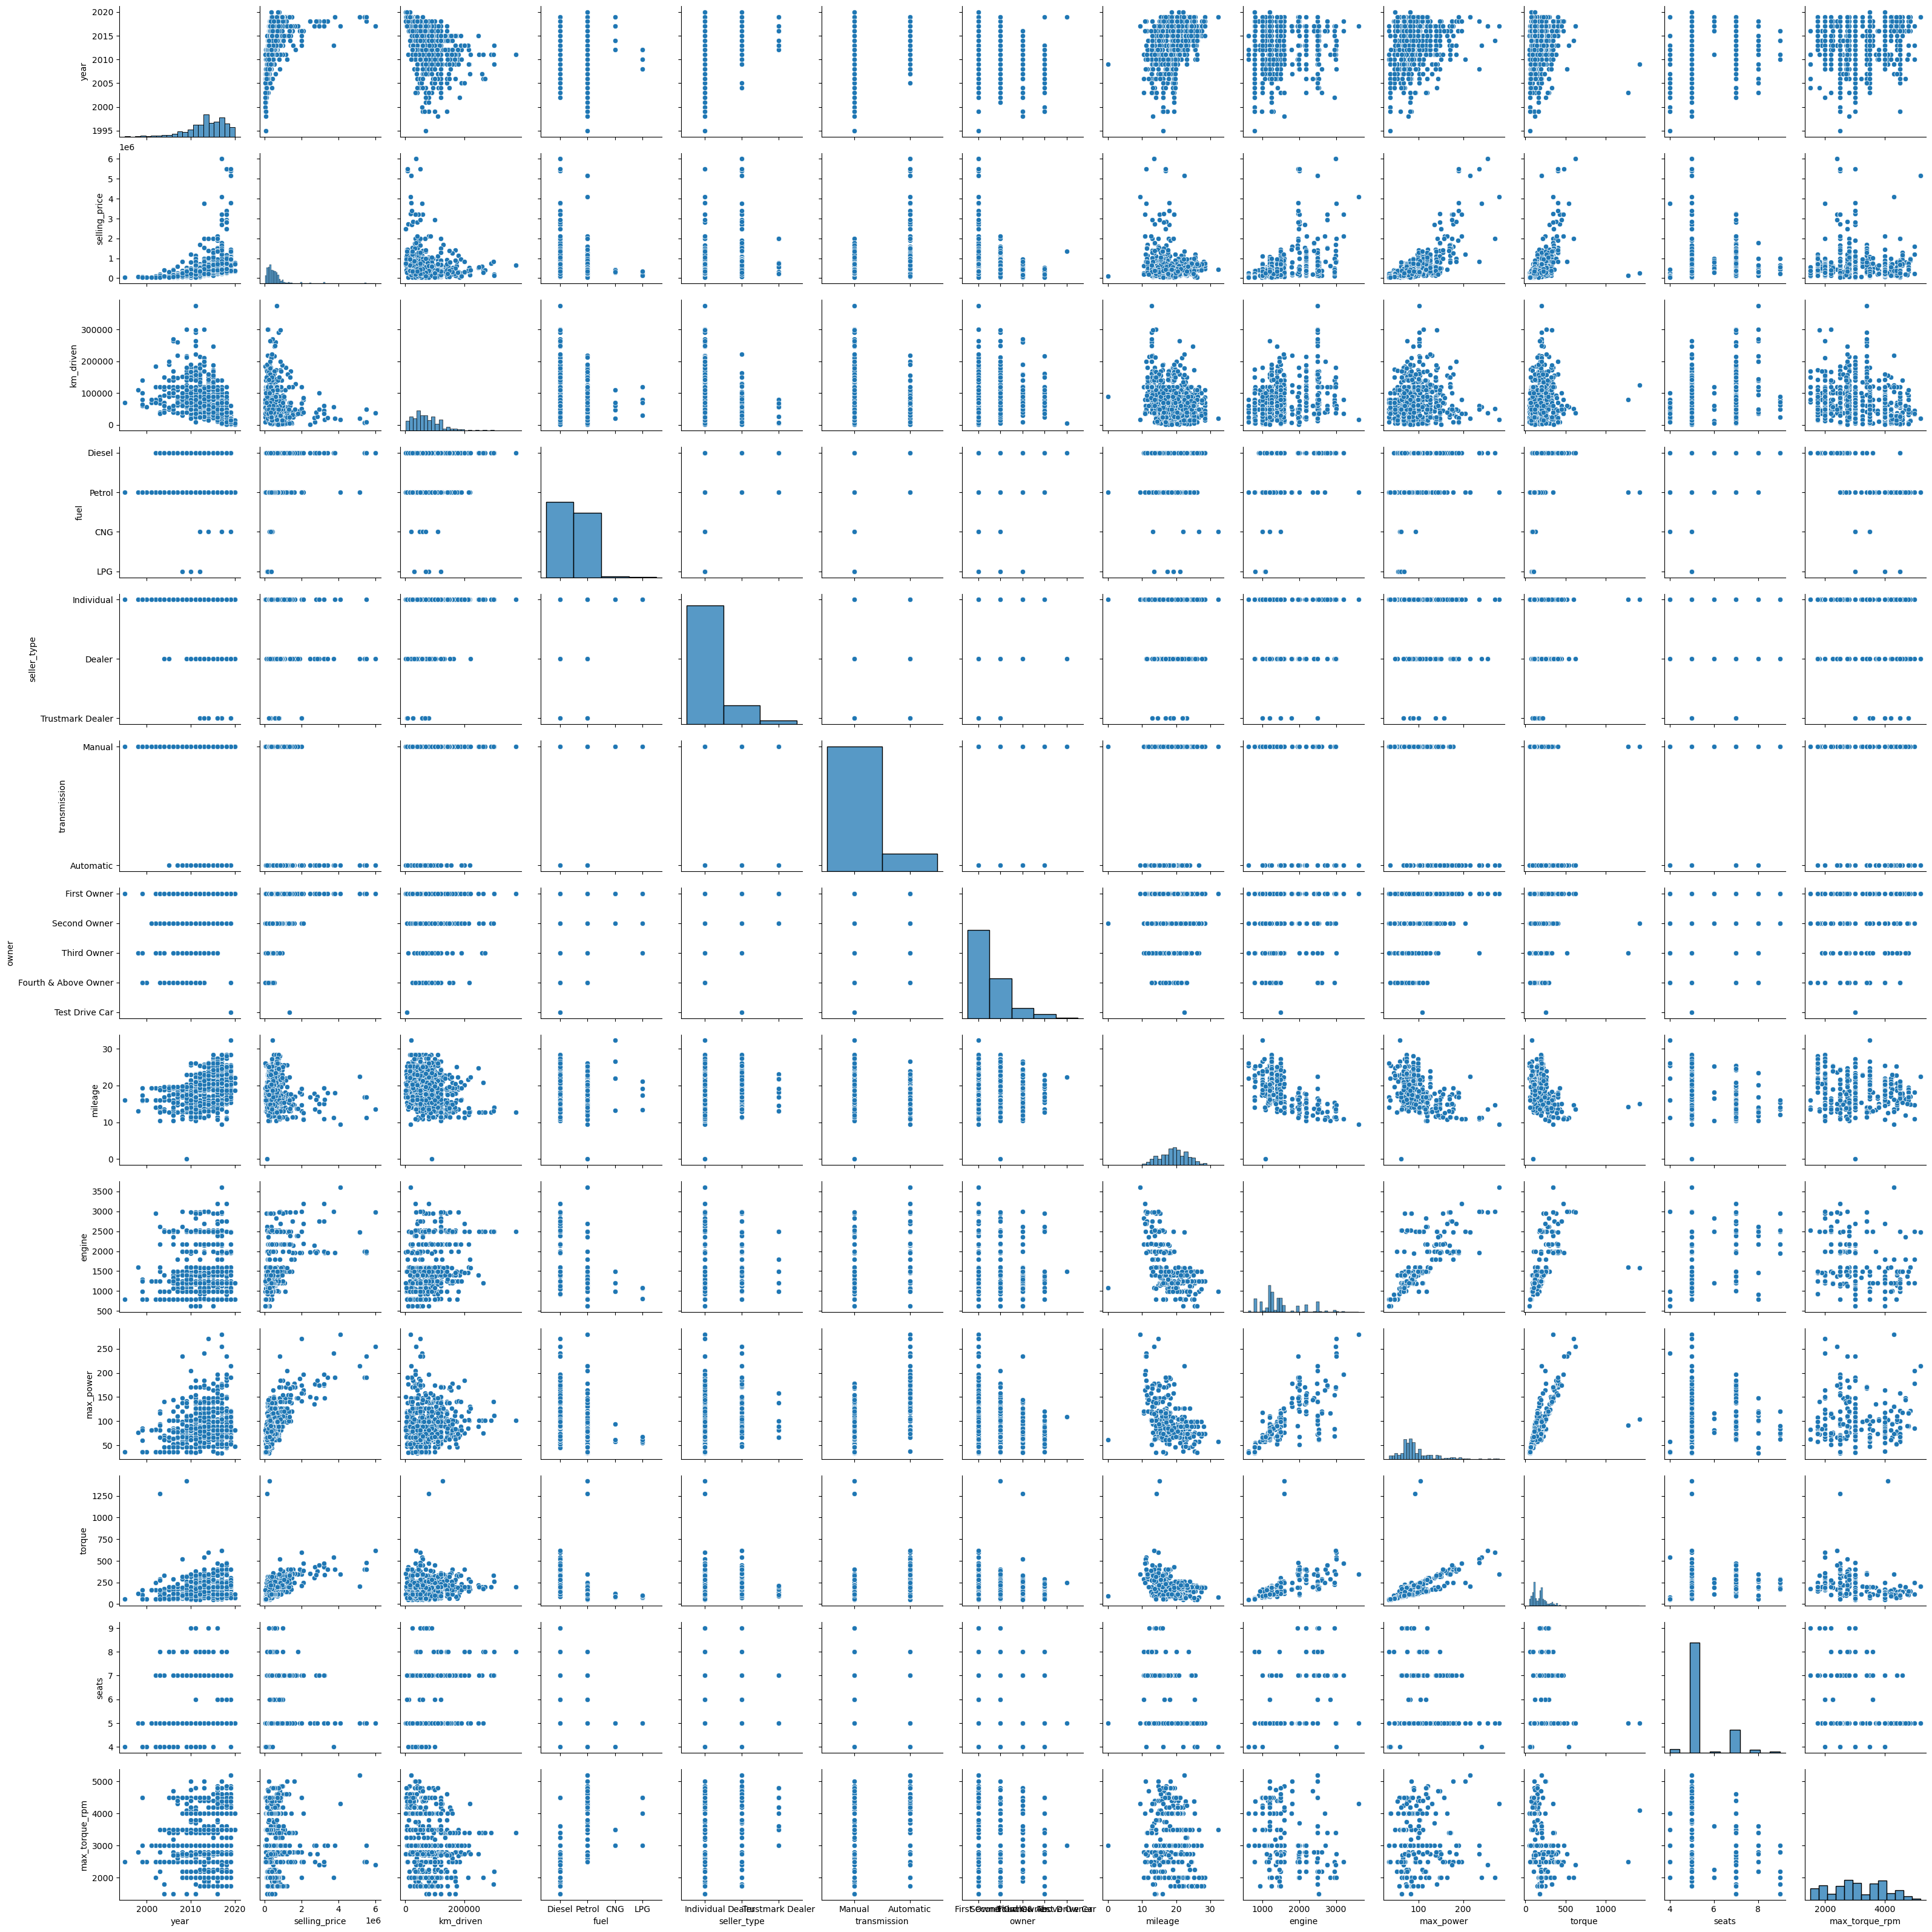

In [33]:
%matplotlib inline

sns.pairplot(df_test, x_vars=cols, y_vars=cols)
plt.show()

- Мы видим примерно такие же распределения в тестовом датасете, как и в тренировочном. Также мы снова видим, что year, km_driven, engine, max_power, torque, owner, transmission коррелируют с целевой переменной selling_price.

Хотя графики немного отличаются друг от друга на тестовом и тренировочном датасетах, но общие тенденции сохраняются.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [x] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [x] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

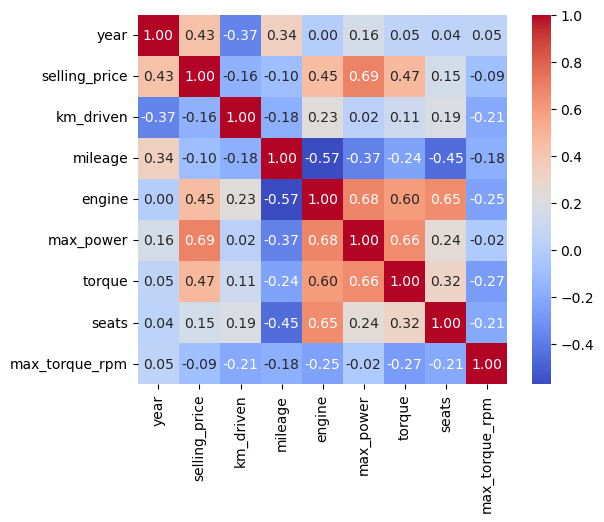

In [34]:
numeric_cols = df_train.select_dtypes(include=['number']).columns.tolist()
cor = df_train[numeric_cols].corr()
sns.heatmap(cor, annot=True, square=True, fmt='.2f', cmap='coolwarm')
plt.show()

- [x] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?

        max_power и km_driven - корреляция между ними равна нулю
 - Между какими наблюдается довольно сильная положительная линейная зависимость?

        engine и max_power - вполне логично коррелируют 
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

        Правильно, поскольку у них отрицательная корреляция.

 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

        По умолчанию мы использовали корреляцию Пирсона. Также есть корреляция Спирмена и Кэндэла.
    

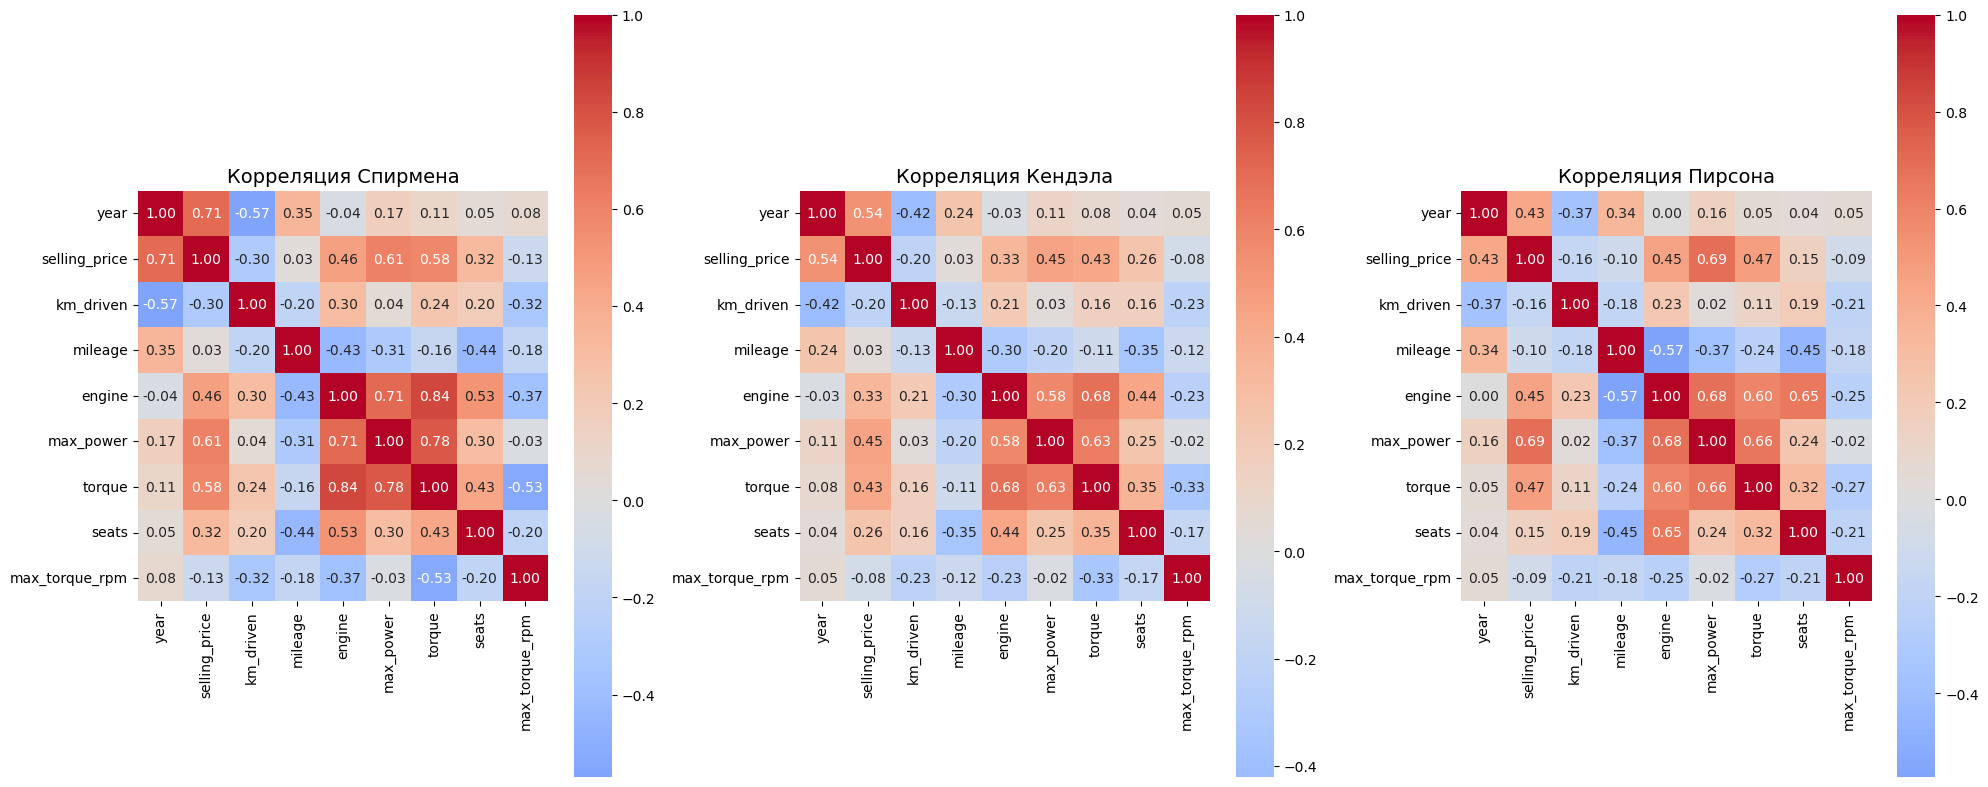

In [35]:
cor_spearman = df_train[numeric_cols].corr(method='spearman')
cor_kendall = df_train[numeric_cols].corr(method='kendall')
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

sns.heatmap(cor_spearman, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Корреляция Спирмена', fontsize=14)

sns.heatmap(cor_kendall, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Корреляция Кендэла', fontsize=14)

sns.heatmap(cor, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title('Корреляция Пирсона', fontsize=14)


plt.tight_layout()
plt.show()

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы

In [36]:
# корреляция Спирмена
# буду использовать pandas только для приведения датафрейма к numpy, в остальных случаях - только numpy

def spearman_corr(df):
    df = np.array(df)
    rank_df = []
    for col in df.T:
        rank_map = {i: count+1 for count, i in enumerate(np.unique(col))}
        rank_df.append([rank_map[i] for i in col])
    rank_df = np.array(rank_df)
    matrix = []
    n_features = df.shape[1]
    for count_i, i in enumerate(rank_df):
        matrix.append([])
        for count_j, j in enumerate(rank_df):
            if count_i == count_j:
                matrix[count_i].append(1)
            else:
                i_std = i - i.mean()
                j_std = j - j.mean()
                value = sum(i_std * j_std) / (np.sqrt(sum(i_std**2)) * np.sqrt(sum(j_std**2)))
                matrix[count_i].append(value)

    return np.array(matrix)
my_corr = spearman_corr(df_train[numeric_cols])

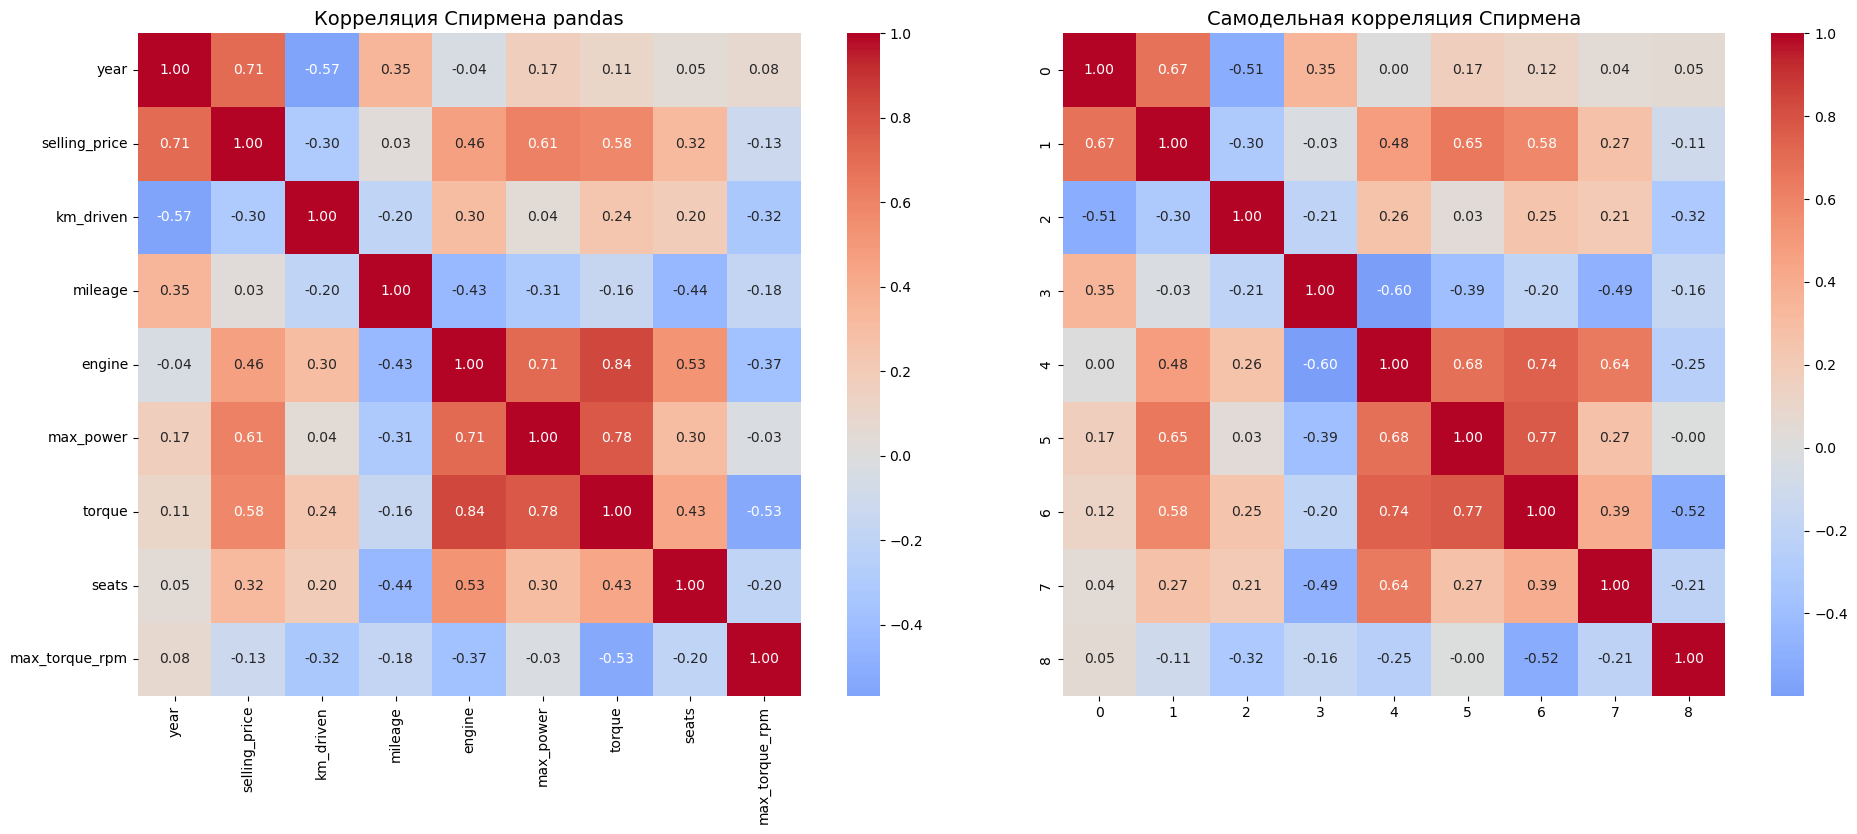

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cor_spearman, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Корреляция Спирмена pandas', fontsize=14)

sns.heatmap(my_corr, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Cамодельная корреляция Спирмена', fontsize=14)

plt.tight_layout()
plt.show()

Есть небольшие расхождения с методом в pandas. Возможно, это происходит из-за того, что ранги в моей корреляции повторялись, а не вычитались по среднему арифметическому. Тем не менее, заметно общее сходство методов.



Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [x] Проинтерпретируйте результаты


In [38]:
corr_phik = df_train.drop(columns=['name']).phik_matrix()

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


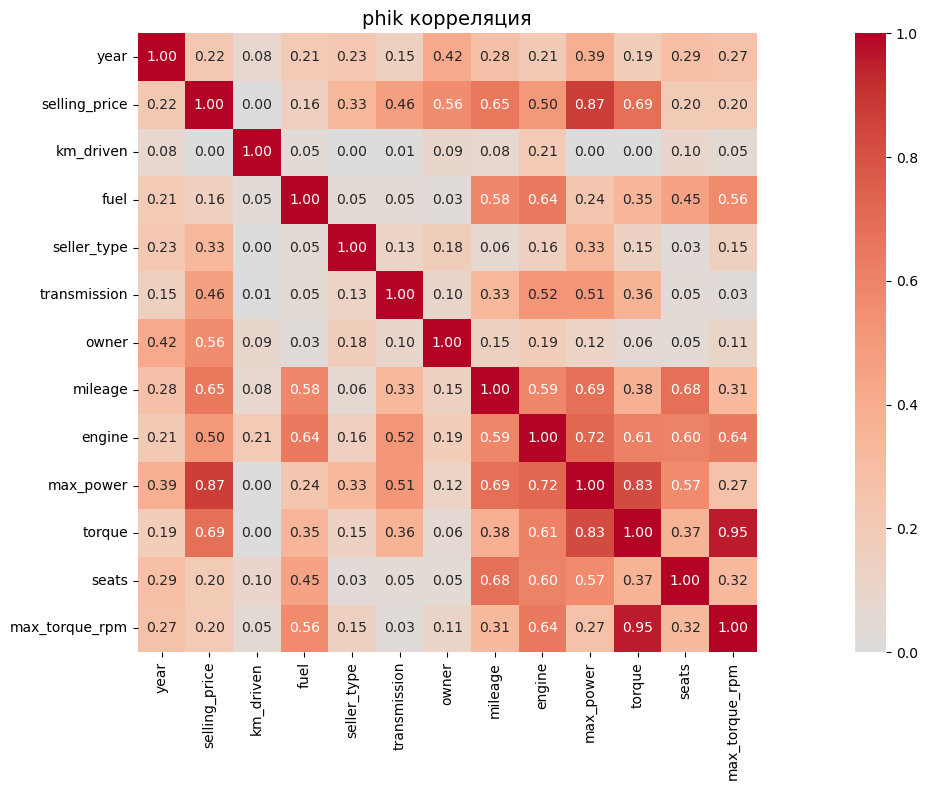

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8))

axes.set_title('phik корреляция', fontsize=14)
sns.heatmap(corr_phik, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes)
plt.tight_layout()
plt.show()

Мы видим, что phik корреляция находит некоторые интересные закономерности, например:
- selling_price коррелирует с max_power, torque, mileage, owner
- transmission коррелирует с engine, max_power, torque
- max_power сильно коррелирует с mileage, torque, engine

При этом некоторые закономерности, которые мы могли наблюдать раньше (или которые просто логичны) не "ловятся" этим методом:
- year и km_driven явно должны быть связаны между собой, но метод показывает лишь 0.08 между ними
- то же можно сказать и про km_driven - selling_price, поскольку от пробега неизбежно должна падать цена
Однако это скорее исключение (для km_driven все корреляции получились низкими). Скорее всего это связано с тем, что область значений у параметра km_driven очень большая и из-за этого коэффициент получается таким низким. Можно поробовать убрать выбросы и после этого построить матрицу зависимостей.

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

Уберу выбросы из колонки km_driven, чтобы посмотреть новые зависимости в phik:

In [40]:
df_noanomaly = df_train.drop(columns=['name']).copy(deep=True)
df_noanomaly = df_noanomaly[df_noanomaly['km_driven'] < df_noanomaly['km_driven'].quantile(0.99)]

corr_phik = df_noanomaly.phik_matrix()

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


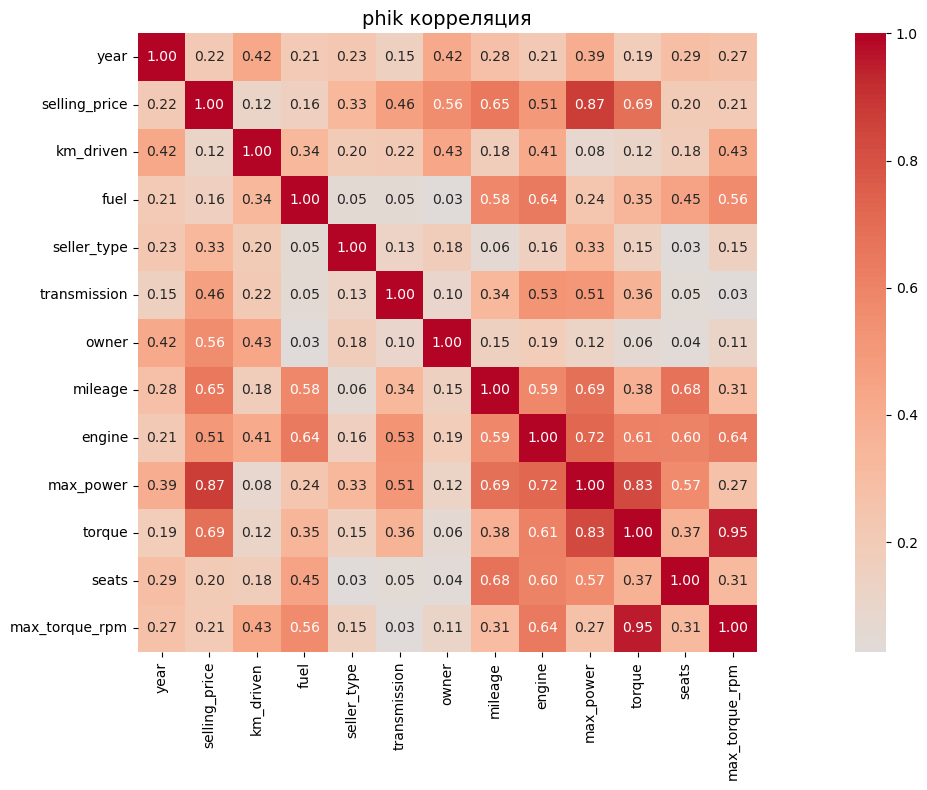

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8))

axes.set_title('phik корреляция', fontsize=14)
sns.heatmap(corr_phik, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes)
plt.tight_layout()
plt.show()

Действительно, корреляции стали больше - это видно на примере признаков year и owner. Однако ожидаемого эффекта на коэффициент корреляции с selling_price не произошло. Значит пробег в данном случае не так сильно влияет на целевую переменную.
Попробую убрать записи с аномальным selling_price и посмотреть новые корреляции.

In [42]:
df_noanomaly = df_noanomaly[df_noanomaly['selling_price'] < df_noanomaly['selling_price'].quantile(0.99)]
corr_phik = df_noanomaly.phik_matrix()

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


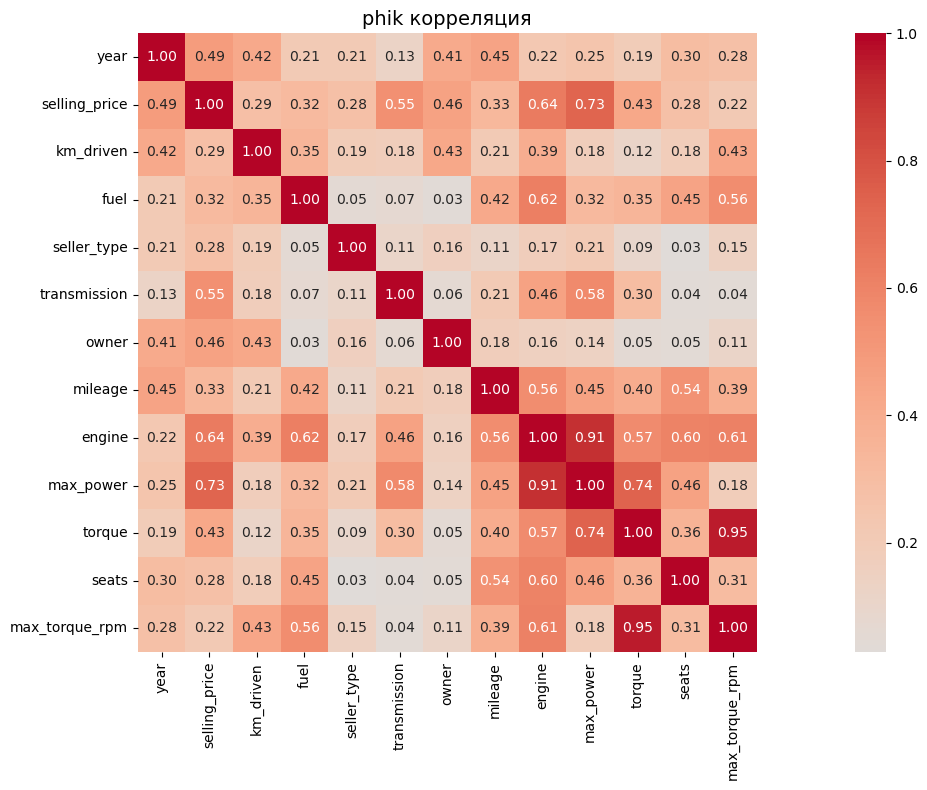

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8))

axes.set_title('phik корреляция', fontsize=14)
sns.heatmap(corr_phik, annot=True, square=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes)
plt.tight_layout()
plt.show()

В целом, корреляции для selling_price перераспределились - для transmission и year корреляции увеличились, а для max_power, mileage и torque уменьшились. 

<h3> Попробую посмотреть на корреляции признаков более детально:

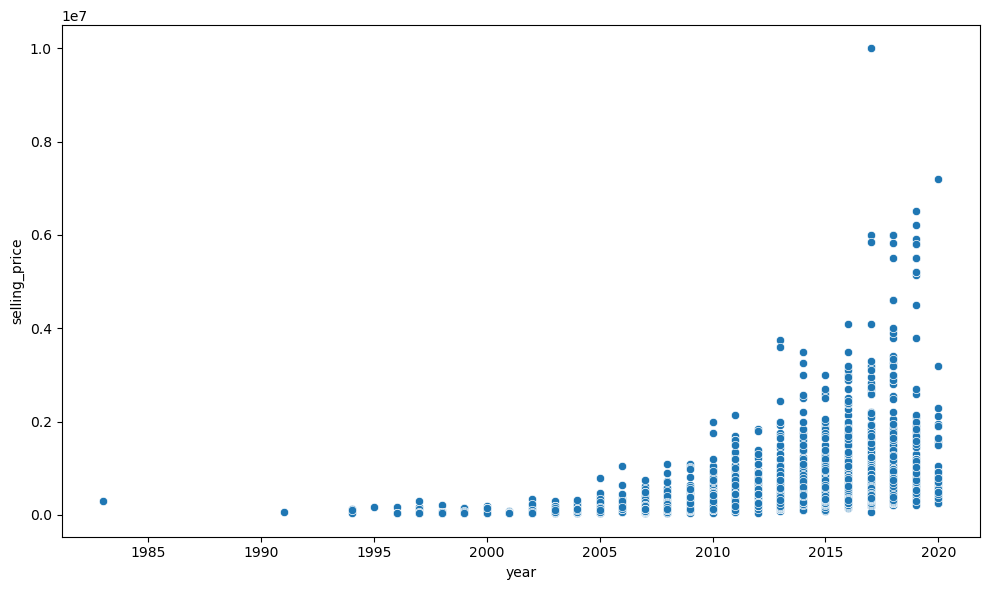

In [44]:
# возьмем для начала year и selling_price

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['year'], y=df_train['selling_price'])

plt.tight_layout()
plt.show()

Здесь видна даже не линейная, а квадратичная зависимость - это стоит учесть при обучении модели.

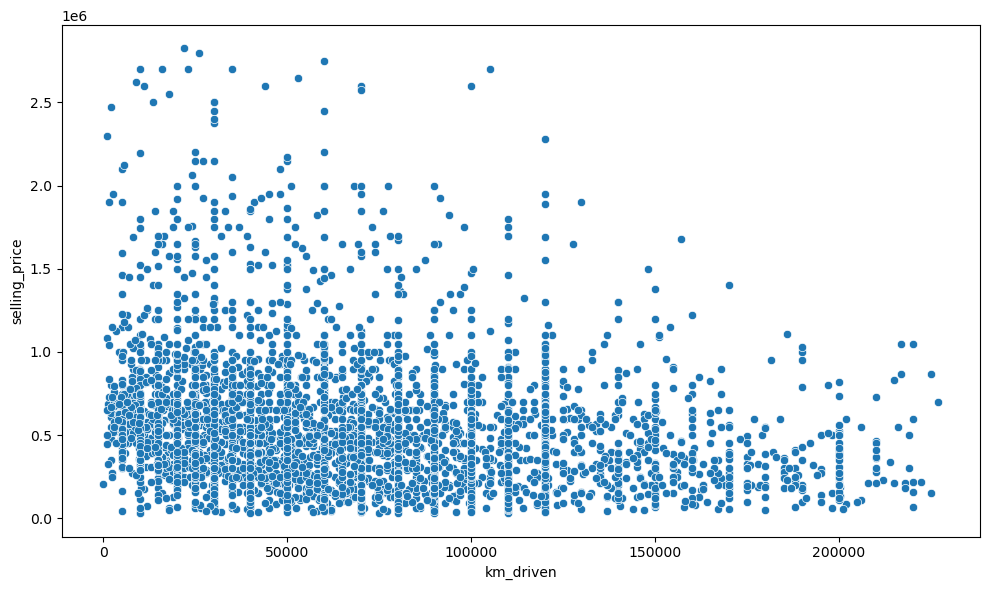

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_noanomaly['km_driven'], y=df_noanomaly['selling_price'])

plt.tight_layout()
plt.show()

Видно, что на знаковых отрезках (100.000 км, например) скапливается большое количество записей. Попробуем разбить на бины и сделать корреляцию теперь

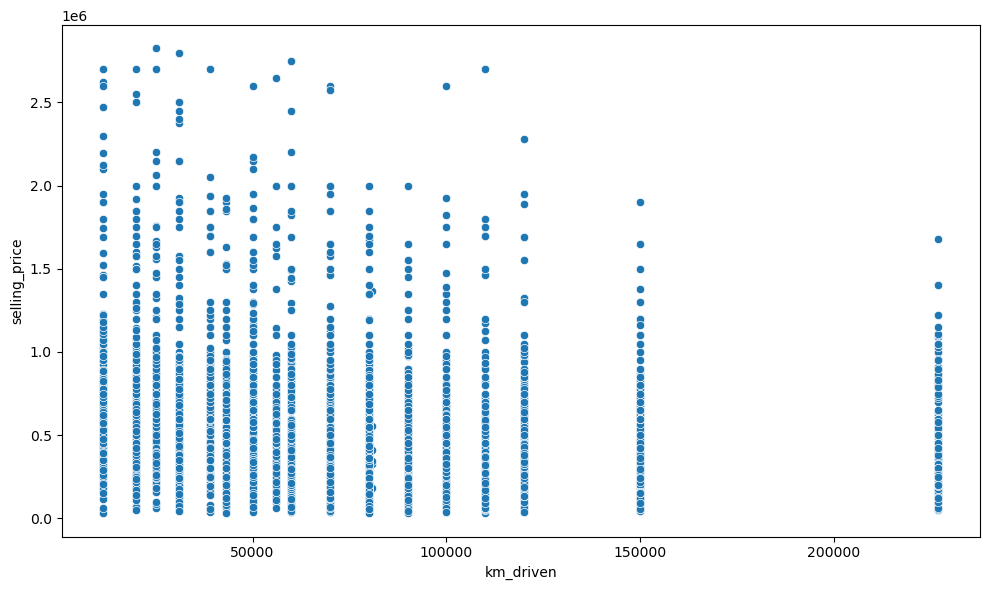

In [46]:
km_bins = pd.qcut(df_noanomaly['km_driven'], q=20, duplicates='drop').apply(lambda x: float(str(x).split()[1].strip(']')))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=km_bins, y=df_noanomaly['selling_price'])

plt.tight_layout()
plt.show()

В общем, есть небольшая обратная линейная зависимость. Можно это учесть

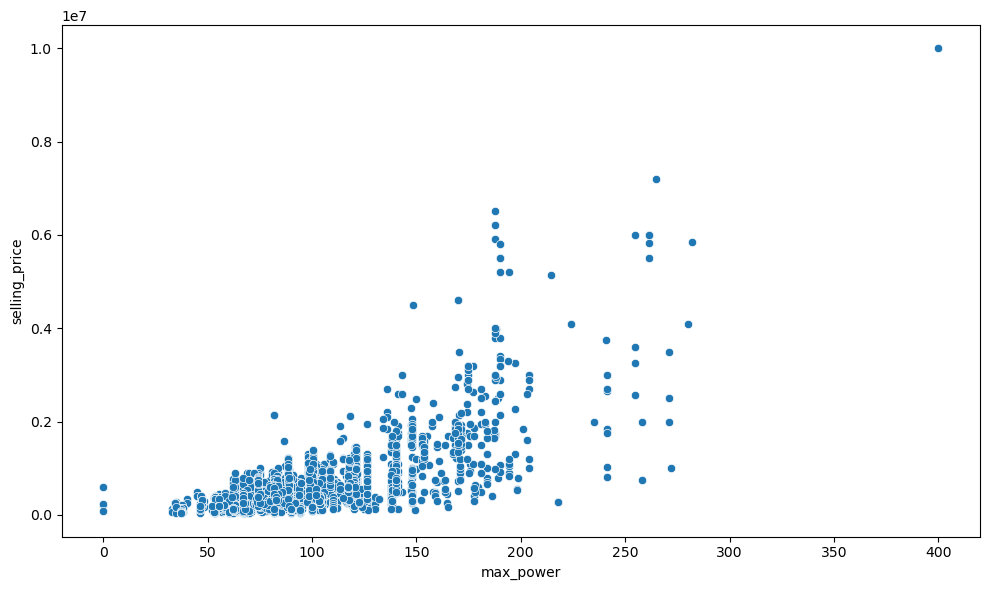

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['max_power'], y=df_train['selling_price'])

plt.tight_layout()
plt.show()

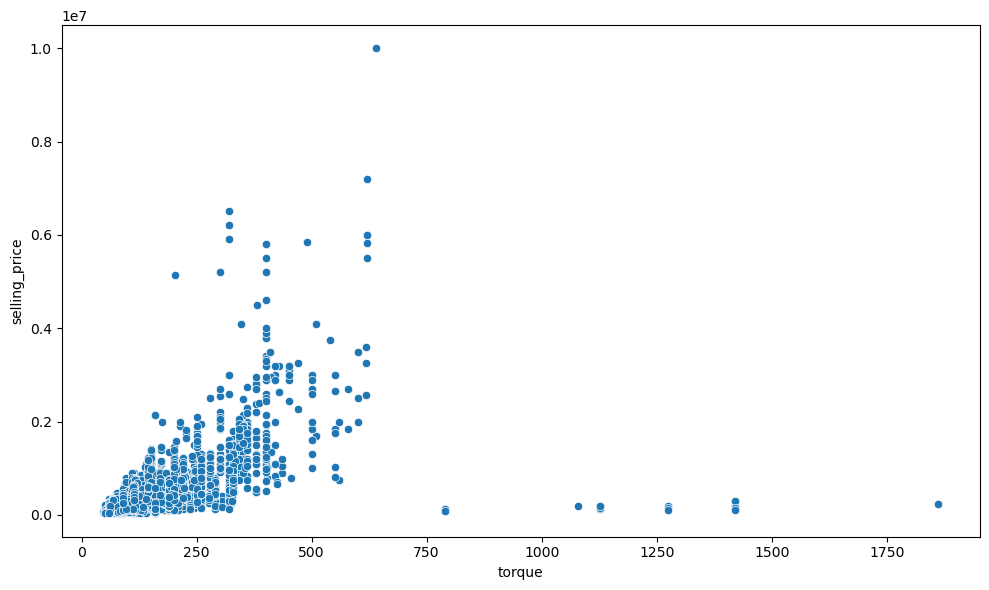

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['torque'], y=df_train['selling_price'])

plt.tight_layout()
plt.show()

<h3> Теперь рассмотрю категориальные признаки:

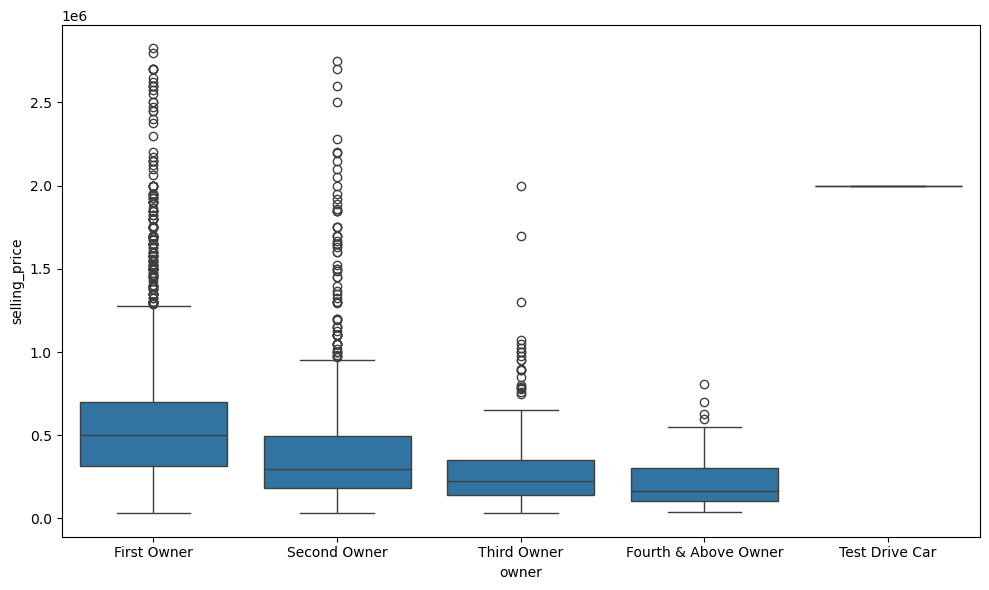

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_noanomaly['owner'], y=df_noanomaly['selling_price'])

plt.tight_layout()
plt.show()

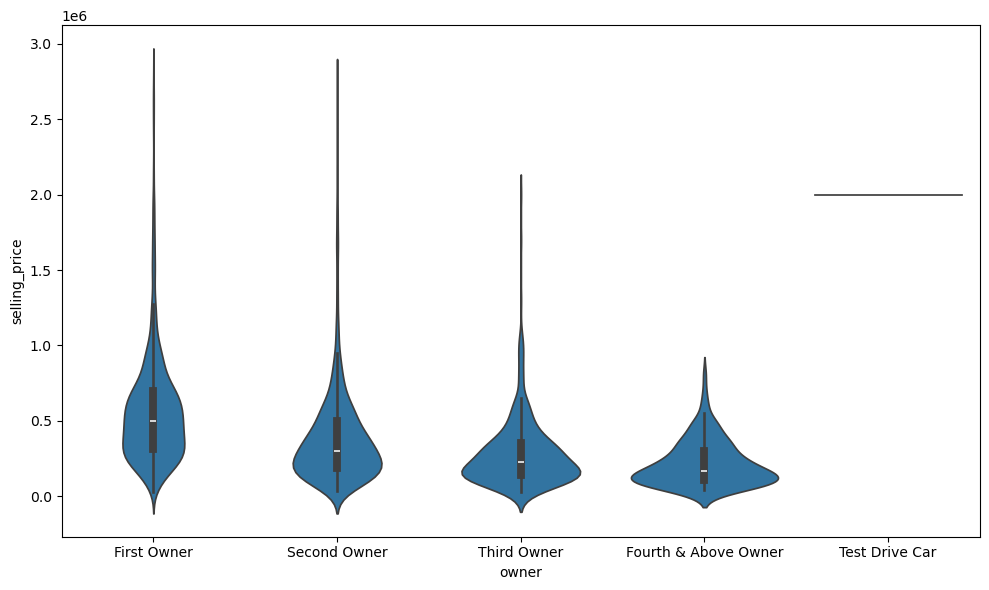

In [50]:
# тот же признак, но violinplot
# благодаря данной визуализации лучше видно, какая плоность распределения у признака 
plt.figure(figsize=(10, 6))
sns.violinplot(x=df_noanomaly['owner'], y=df_noanomaly['selling_price'])

plt.tight_layout()
plt.show()

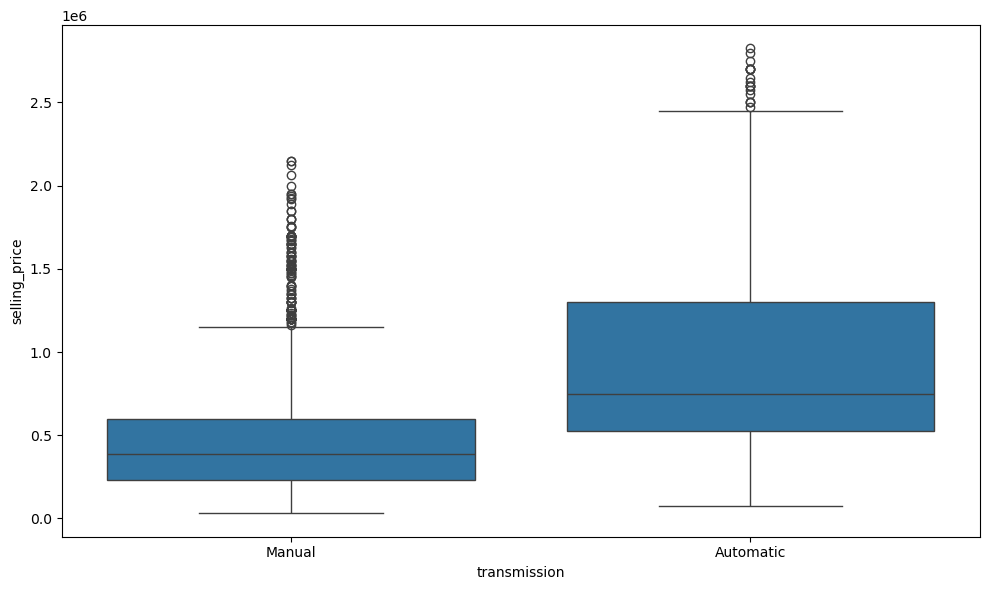

In [51]:
# видно, что АКПП в среднем дороже МКПП
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_noanomaly['transmission'], y=df_noanomaly['selling_price'])

plt.tight_layout()
plt.show()

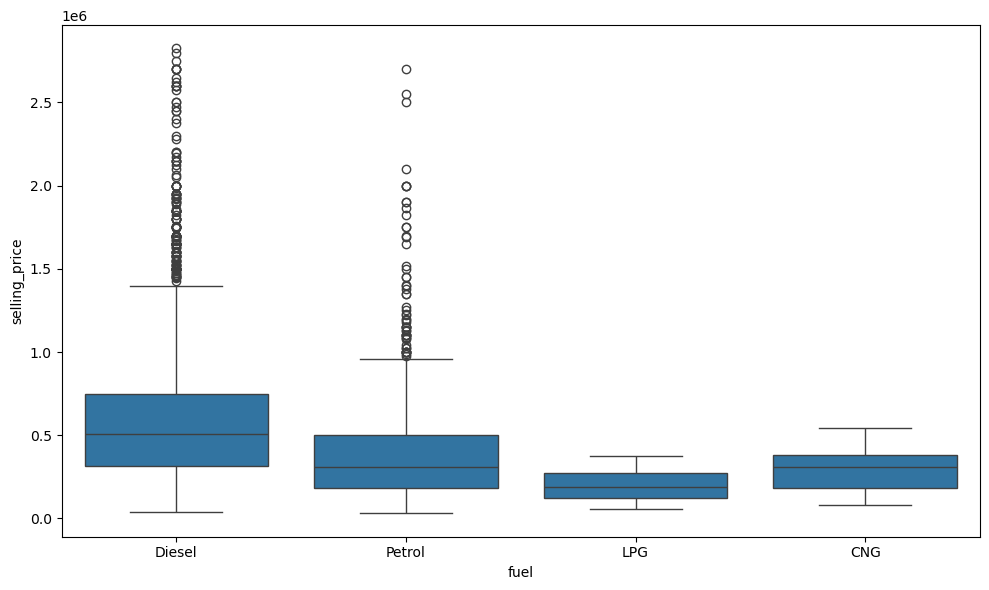

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_noanomaly['fuel'], y=df_noanomaly['selling_price'])

plt.tight_layout()
plt.show()

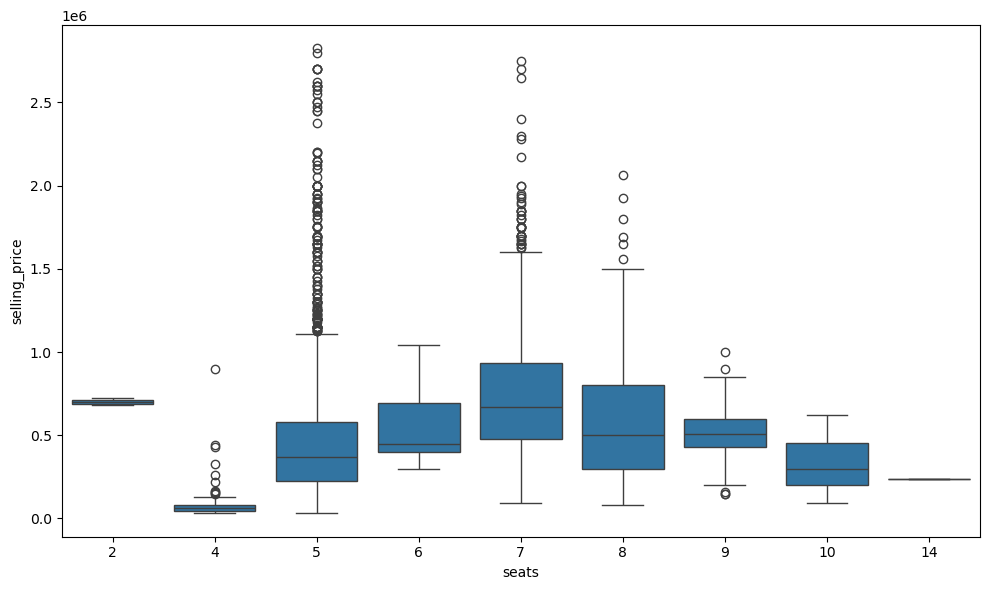

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_noanomaly['seats'], y=df_noanomaly['selling_price'])

plt.tight_layout()
plt.show()

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [54]:
df_train_numerical = df_train.select_dtypes(include=['number']).copy(deep=True)
df_test_numerical = df_test.select_dtypes(include=['number']).copy(deep=True)

In [55]:
y_train = df_train_numerical['selling_price']
X_train = df_train_numerical.drop(columns=['selling_price'])
y_test = df_test_numerical['selling_price']
X_test = df_test_numerical.drop(columns=['selling_price'])

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [56]:
def print_metrics(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {MSE(y_true, y_pred)}")
    print(f"MAE: {MAE(y_true, y_pred)}")

In [57]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_default = lr.predict(X_test)
print_metrics(y_test, y_pred_default)

R2: 0.5998086106849407
MSE: 230041438298.91794
MAE: 220872.74449095174


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [58]:
def r2(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - y_true.mean())**2)

В R2 (простыми словми) мы смотрим, насколько предсказания модели лучше, чем среднее по всему датасету.

R2 = 1 - Сумма квадратов разности предсказания и реального значения / Сумма квадратов разности предсказания и среднего значения

ИЛИ

R2 = 1 - SSE / SST

        SSE в данном случае отражает "неточность" наших предсказаний
        SST отражает неточность среднего как предсказания

В случае если модель предсказыват значения идеально, в числителе у нас будет стоять 0 ->. Тогда R2 будет равен 1 - это лучшее из возможных значений этой метрики.

При этом если модель предсказывает хуже, чем простое среднее значение, то числитель будет больше знаменателя, поэтому мы будем вычитать из единицы число больше единицы и получим R2 <= 0, что является плохим значением.


### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [59]:
def adjustedR2(y_true, y_pred, n_features):
    objects = len(y_true)
    return 1 - (1 - r2(y_true, y_pred)) * (objects - 1) / (objects - n_features - 1)

AdjustedR2 нужна, чтобы штрафовать модель за излишнее число признаков. Чем их больше - тем больше знаменатель, и соответственно предсказания должны становиться лучше при добавлении новых признаков, иначе эта метрика будет падать.

Таким образом, adjustedR2 может применяться при выборе признаков или для того, чтобы не позволить модели переобучиться.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [x] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [60]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_scaled = lr.predict(X_test)
print_metrics(y_test, y_pred_scaled)

R2: 0.5998086106849454
MSE: 230041438298.9152
MAE: 220872.74449095278


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [x] Какой признак оказался наиболее информативным в предсказании цены?

In [62]:
list(zip(lr.coef_, df_train_numerical.drop(columns='selling_price').columns))

[(np.float64(165179.40181690766), 'year'),
 (np.float64(-49064.438117673824), 'km_driven'),
 (np.float64(-8266.0900159887), 'mileage'),
 (np.float64(22301.18803829109), 'engine'),
 (np.float64(327717.7530182931), 'max_power'),
 (np.float64(8847.336293579368), 'torque'),
 (np.float64(-29593.864209463474), 'seats'),
 (np.float64(-57703.43043297079), 'max_torque_rpm')]

In [63]:
# Вот какой признак имеет наибольший вес в предсказании цены
max(zip(lr.coef_, df_train_numerical.drop(columns='selling_price').columns), key=lambda x: x[0])[1]

'max_power'

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [64]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print_metrics(y_test, y_pred_lasso)
print(f"Веса модели: {lasso.coef_}")

R2: 0.5998073250281062
MSE: 230042177331.17914
MAE: 220872.48401224523
Веса модели: [165177.20266981 -49063.49207834  -8262.81785419  22299.1523909
 327719.18469908   8846.68816921 -29589.87379008 -57701.36080842]


Никакие веса не занулились. Это могло произойти по причине того, что все они действительно дают хороший вклад в результат модели и они не должны быть регуляризованы. Вторая причина может заключаться в том, что гиперпараметр alpha при обучении модели слишком мал, чтобы занулить какие-то признаки за такое количество эпох, которое она обучалась. 

In [65]:
# попробую поставить alpha = 10000
lasso = Lasso(alpha = 10000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print_metrics(y_test, y_pred_lasso)
print(f"Веса модели: {lasso.coef_}")

R2: 0.586217971244624
MSE: 237853725938.59805
MAE: 219170.06427369238
Веса модели: [153408.7500499  -39292.58451922      0.              0.
 334045.90303755   3807.0278643      -0.         -44234.87923756]


Как видно, при другом значении alpha один признак занулился

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [x] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [x] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [66]:
lasso = Lasso()

param_grid = {
    'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 30000, 100000],
    'max_iter': [100, 500, 1000, 5000, 10000],
    'tol': [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

gs = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error'
)

gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 30000,
                                   100000],
                         'max_iter': [100, 500, 1000, 5000, 10000],
                         'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [67]:
y_pred_gs_lasso = gs.predict(X_test)
print_metrics(y_test, y_pred_gs_lasso)
print(f"Веса модели: {gs.best_estimator_.coef_}")

R2: 0.586217971244624
MSE: 237853725938.59805
MAE: 219170.06427369238
Веса модели: [153408.7500499  -39292.58451922      0.              0.
 334045.90303755   3807.0278643      -0.         -44234.87923756]


- Всего я перебирал 9 * 5 * 5 сочетаний параметров. И для каждого сочетания еще 10 фолдов. Итого 9 * 5 * 5 * 10 = 2250 моделей обучил грид серч

- значение каждого перебранного параметра:
        
        alpha - степерь регуляризации (чем больше - тем меньше вероятность переобучения и тем скорее признак занулится)
        max_iter - сколько "эпох" максимально модель пройдет по градиентному спуску
        tol - порог изменения градиента, после которого модель прекращает работу. То есть, если изменение слишком слабое, модель не будет дальше искать оптимизацию
- коэффициент регуляризации у лучшей из моделей равен 1000. Ни один вес при таком коэффциенте регуляризации не занулится

**Ваша задача 2:**

- [x] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [x] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [68]:
elastic = ElasticNet(tol=0.0001, max_iter = 1000)

# попробую другие параметры, потому что tol и max_iter не так сильно нужны в переборе параметров
# и у нас появляется новый параметр l1_ratio
param_grid = {
    'alpha': [1, 10, 100, 1000, 10000, 30000, 100000],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

gs = GridSearchCV(
    estimator=elastic,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error'
)

gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': [1, 10, 100, 1000, 10000, 30000, 100000],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error')

In [69]:
y_pred_gs_elastic = gs.predict(X_test)
print_metrics(y_test, y_pred_gs_elastic)
print(f"Веса модели: {gs.best_estimator_.coef_}")

R2: 0.586217971244624
MSE: 237853725938.59805
MAE: 219170.06427369238
Веса модели: [153408.7500499  -39292.58451922      0.              0.
 334045.90303755   3807.0278643      -0.         -44234.87923756]


- Грид серчу пришлось обучать 7 * 10 * 10 моделей = 700
- Лучшие гиперпараметры по MSE: alpha=1000, l1_ratio=1

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



[x] Реализуйте модель с $L0$-регуляризаицей.

In [70]:
class L0Regression:
    def __init__(self, alpha=1.0, threshold=0.001, max_iter=1000):
        self.alpha = alpha
        self.coef_ = None
        self.max_iter = max_iter
        self.threshold = threshold
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        m, n = X.shape
        X = np.column_stack((np.ones(m), X))
        n += 1
        w = np.zeros(n)
        w[0] = 1
        for i in range(self.max_iter):
            y_pred = X @ w
            errors = y_pred - y
            grad_mse = (2.0 / m) * (X.T @ errors)
            w = w - self.alpha * grad_mse
            w[np.abs(w) < self.threshold] = 0 # что-то вроде L0 регуляризации
            # if i % 100 == 0:
            #     print(w)
        self.coef_ = w

    def predict(self, X):
        X = np.array(X)
        return X @ self.coef_[1:] + self.coef_[0]
            

[x] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации


In [71]:
l0 = L0Regression(alpha=0.001, max_iter=10000, threshold=10)
l0.fit(X_train, y_train)
y_pred_l0 = l0.predict(X_test)
print_metrics(y_test, y_pred_l0)
print(f"Веса модели: {l0.coef_}")

R2: 0.5993924691154269
MSE: 230280648356.2627
MAE: 220880.0066896507
Веса модели: [522960.09003936 162577.37430471 -49684.36280451      0.
  31648.35630677 324388.71787808   9112.69809139 -30663.08210076
 -54000.99112235]


In [72]:
l0 = L0Regression(alpha=0.001, max_iter=10000, threshold=100)
l0.fit(X_train, y_train)
y_pred_l0 = l0.predict(X_test)
print_metrics(y_test, y_pred_l0)
list(zip(l0.coef_, df_train_numerical.drop(columns='selling_price').columns))

R2: 0.5894810114124822
MSE: 235978037271.91788
MAE: 224555.30962862461


[(np.float64(522960.0900393595), 'year'),
 (np.float64(161113.33231843694), 'km_driven'),
 (np.float64(-43629.355951030724), 'mileage'),
 (np.float64(0.0), 'engine'),
 (np.float64(17617.669693468877), 'max_power'),
 (np.float64(316591.3760485146), 'torque'),
 (np.float64(26790.86772538351), 'seats'),
 (np.float64(0.0), 'max_torque_rpm')]

In [73]:
l0 = L0Regression(alpha=0.001, max_iter=10000, threshold=1000)
l0.fit(X_train, y_train)
y_pred_l0 = l0.predict(X_test)
print_metrics(y_test, y_pred_l0)

list(zip(l0.coef_, df_train_numerical.drop(columns='selling_price').columns))

R2: -0.015680822169978237
MSE: 583842339997.6362
MAE: 375217.60256724287


[(np.float64(522960.0900393633), 'year'),
 (np.float64(0.0), 'km_driven'),
 (np.float64(0.0), 'mileage'),
 (np.float64(0.0), 'engine'),
 (np.float64(0.0), 'max_power'),
 (np.float64(0.0), 'torque'),
 (np.float64(0.0), 'seats'),
 (np.float64(0.0), 'max_torque_rpm')]

In [74]:
l0 = L0Regression(alpha=0.001, max_iter=10000, threshold=300)
l0.fit(X_train, y_train)
y_pred_l0 = l0.predict(X_test)
print_metrics(y_test, y_pred_l0)

list(zip(l0.coef_, df_train_numerical.drop(columns='selling_price').columns))

R2: 0.5800063280554562
MSE: 241424355821.16882
MAE: 228480.19755036687


[(np.float64(522960.0900393592), 'year'),
 (np.float64(176197.11109468696), 'km_driven'),
 (np.float64(0.0), 'mileage'),
 (np.float64(0.0), 'engine'),
 (np.float64(3842.0867789773138), 'max_power'),
 (np.float64(324171.58411779033), 'torque'),
 (np.float64(24324.476436548837), 'seats'),
 (np.float64(0.0), 'max_torque_rpm')]

[x] Проанализируйте результаты обучения

Мы обучили модель на нескольких значениях threshold и это позволило нам увидеть, какие признаки будут зануляться в первую очередь.

- При пороговом значении 100 зануляются такие признаки, как max_power, seats, max_torque_rpm
- При пороговом значении 1000 зануляются все признаки, кроме year, однако это не дает хорошего результата - скорее наоборот, предсказание сильно теряет в точности. 

В общем, данная регуляризация требует внимательного подхода, так как она очень жестко зануляет признаки и не всегда отбирает действительно самые важные.

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [x] Предобработайте столбец `name`, чтобы избежать его удаления

In [75]:
# тут мы добавляем столбцы с категориальными признаками

df_train_cat = df_train_numerical.copy(deep=True)
df_train_cat['name'] = df_train['name']
df_train_cat[df_train.select_dtypes('object').columns] = df_train[df_train.select_dtypes('object').columns]

df_test_cat = df_test_numerical.copy(deep=True)
df_test_cat['name'] = df_test['name']
df_test_cat[df_test.select_dtypes('object').columns] = df_test[df_test.select_dtypes('object').columns]

In [76]:
# количество уникальных наименований до преобрзаования
len(df_train_cat['name'].unique())

1924

In [77]:
# допустим, мы будем брать только производителя
# хотя можно бы было взять бренд + марку и сделать более точный признак, но нам надо будет закодировать значения
# через one-hot encoding, поэтому лучше чтобы у нас было 30 уникальных значений, а не 200+
df_train_cat['name'] = df_train_cat['name'].apply(lambda x: (x.split()[0]))
df_test_cat['name'] = df_test_cat['name'].apply(lambda x: (x.split()[0]))

In [78]:
# количество уникальных наименований после преобразования
# нам удалось сильно сокртатить количество униакльных наименований 
len(df_train_cat['name'].unique())

30

In [79]:
X_train_cat = df_train_cat.drop(columns='selling_price')
y_train_cat = df_train_cat['selling_price']

X_test_cat = df_test_cat.drop(columns='selling_price')
y_test_cat = df_test_cat['selling_price']

### **Задание 20 (0.1 балла)**

- [x] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [80]:
set(df_test_cat.name) - set(df_train_cat.name) # это не очень хорошо, но ладно (в тесте есть марки авто, которых нет в трейне)

{'Ashok', 'Opel'}

In [81]:
def add_ohe_features(train_df, test_df, columns):
    ohc = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

    for col in columns:
        ohc.fit(train_df[[col]])

        train_encoded = ohc.transform(train_df[[col]])
        train_df[ohc.get_feature_names_out([col])] = train_encoded

        test_encoded = ohc.transform(test_df[[col]])
        test_df[ohc.get_feature_names_out([col])] = test_encoded

    return train_df, test_df

X_train_cat, X_test_cat = add_ohe_features(
    X_train_cat, 
    X_test_cat, 
    columns=['name', 'fuel', 'seller_type', 'transmission', 'owner']
)
X_train_cat = X_train_cat.drop(columns=['name', 'fuel', 'seller_type', 'transmission', 'owner'])
X_test_cat = X_test_cat.drop(columns=['name', 'fuel', 'seller_type', 'transmission', 'owner'])

/Users/danil/miniforge3/envs/datascience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [82]:
scaler = StandardScaler()
scaler.fit(X_train_cat)
X_train = scaler.transform(X_train_cat)
X_test = scaler.transform(X_test_cat)

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

ОТВЕТЫ:
- Для корректной работы нужно во-первых обучать OneHot на train, чтобы избежать появления новых категорий в test. Также нельзя использовать OneHot если у признака есть слишком много уникальных значений, поскольку каждое уникальное значение создает новый признак в матрице, что может сильно удорожить обучение + поспособствовать переобучению (слишком много признаков это в принципе не очень хорошо).
- Удаление одного столбца необходимо для того, чтобы не создавать линейную зависимость между признаками, потому что линейная зависимость плохо влияет на обучение модели.
- Просто так удалять "неважные" признаки некорректно, потому что тем самым мы "подгоняем" модель под train. Хотя, если L1 занулит их полностью, мы можем допустить, что эти признаки абсолютно ничего не значат и удалить их.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [x] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.

In [83]:
ridge = Ridge(tol=0.0001, max_iter = 1000)

param_grid = {
    'alpha': [1, 10, 100, 1000, 10000, 30000, 100000],
    'solver': ['auto']
}

gs = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=10,
    scoring='r2'
)

gs.fit(X_train_cat, y_train_cat)

GridSearchCV(cv=10, estimator=Ridge(max_iter=1000),
             param_grid={'alpha': [1, 10, 100, 1000, 10000, 30000, 100000],
                         'solver': ['auto']},
             scoring='r2')

In [84]:
y_pred_gs_ridge = gs.predict(X_test_cat)
print_metrics(y_test, y_pred_gs_ridge)
print(f"Веса модели: {gs.best_estimator_.coef_}")

R2: 0.7810011504171378
MSE: 125886792392.1976
MAE: 168627.57968170525
Веса модели: [ 3.88415520e+04 -5.39575803e-01  5.92407591e+02  5.83950200e+01
  6.35827056e+03  1.26217670e+02  3.03612972e+03 -5.46048864e+01
  3.90771862e+05  1.00790624e+06 -5.07776154e+05 -1.82610042e+04
 -5.06591113e+05 -5.12701942e+05 -3.53305812e+05 -4.44355509e+05
 -4.48951788e+05 -4.15749090e+05  4.91530697e+04  5.73148665e+05
  7.85401719e+04 -5.08655597e+04  8.30262182e+05  1.53792131e+06
  9.89081277e+04 -4.26351832e+05 -3.65560880e+05  5.47734252e+05
 -1.25751911e+05 -4.59351946e+05 -4.37941953e+04 -4.54802670e+05
 -4.66551603e+05 -5.17367172e+05 -1.43570997e+05 -4.95507513e+05
  1.65661416e+06  2.77626119e+04  1.34120475e+05  3.92039733e+04
 -6.57565515e+04 -4.46888725e+04 -9.69383612e+04 -4.96917987e+04
 -6.17503117e+04  2.50759949e+06 -4.93152086e+04]


- [x] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

Прогноз удалось улучшить значительно: 0.58 -> 0.78 (R2)

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [85]:
# создадим новые датафреймы, с которыми будет удобно работать

df_train_new_features = X_train_cat.copy(deep=True)[list(filter(lambda x: 'name' not in x, X_train_cat.columns))]
df_train_new_features['selling_price'] = df_train['selling_price']
df_train_new_features['name'] = df_train['name'].apply(lambda x: ' '.join(x.split()[:2]))

df_test_new_features = X_test_cat.copy(deep=True)[list(filter(lambda x: 'name' not in x, X_test_cat.columns))]
df_test_new_features['selling_price'] = df_test['selling_price']
df_test_new_features['name'] = df_test['name'].apply(lambda x: ' '.join(x.split()[:2]))

<h3> 1. Новые признаки на основе числовых


In [86]:
# добавим признак квадрата года выпуска автомобиля (корреляция была скорее квадратной, когда мы строили визуализации)
df_train_new_features['year'] = df_train_new_features['year'] ** 2
df_test_new_features['year'] = df_test_new_features['year'] ** 2

# добавим признак отношения числа лошадей на (мили)литр (милилитры - потому что у нас так записаны данные, не 1.6 литра, а 1600)
df_train_new_features['enigne_over_power'] = df_train_new_features['max_power'] / df_train_new_features['engine']
df_test_new_features['enigne_over_power'] = df_test_new_features['max_power'] / df_test_new_features['engine']

# добавим также признак потраченного за все время безнзина - это mileage * km_driven
df_train_new_features['fuel_spent'] = df_train_new_features['km_driven'] / 100 * df_train_new_features['mileage']
df_test_new_features['fuel_spent'] = df_test_new_features['km_driven'] / 100 * df_test_new_features['mileage']

<h3> 2. Новые признаки на основе категориальных


In [87]:
# добавим признак ср. цены по марке и модели автомобиля
means = df_train_new_features.groupby('name')['selling_price'].mean()
df_train_new_features['model_avg_price'] = df_train_new_features['name'].map(means)
df_test_new_features['model_avg_price']  = df_test_new_features['name'].map(means).fillna(
                                            df_train_new_features['selling_price'].mean())

# добавим признак страны производства
def get_country(name):
    # P.S. воспользовался chatgpt для того, чтобы сформировать этот словарь
    manufacturer_country = {
    "Maruti": "India",
    "Skoda": "Czech Republic",
    "Hyundai": "South Korea",
    "Toyota": "Japan",
    "Ford": "USA",
    "Renault": "France",
    "Mahindra": "India",
    "Honda": "Japan",
    "Chevrolet": "USA",
    "Fiat": "Italy",
    "Datsun": "Japan",
    "Tata": "India",
    "Jeep": "USA",
    "Mercedes-Benz": "Germany",
    "Mitsubishi": "Japan",
    "Audi": "Germany",
    "Volkswagen": "Germany",
    "BMW": "Germany",
    "Nissan": "Japan",
    "Lexus": "Japan",
    "Jaguar": "United Kingdom",
    "Land": "United Kingdom",
    "MG": "United Kingdom",
    "Volvo": "Sweden",
    "Daewoo": "South Korea",
    "Kia": "South Korea",
    "Force": "India",
    "Ambassador": "India",
    "Isuzu": "Japan",
    "Peugeot": "France",
    "Opel": "Germany",
    "Ashok": "India"
}
    return manufacturer_country[name.split()[0]]

df_train_new_features['country'] = df_train_new_features['name'].apply(lambda x: get_country(x))
df_test_new_features['country'] = df_test_new_features['name'].apply(lambda x: get_country(x))

ohc = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
ohc.fit(df_train_new_features[['country']])
encoded = ohc.transform(df_train_new_features[['country']])
df_train_new_features = pd.concat([df_train_new_features, pd.DataFrame(encoded, columns=ohc.get_feature_names_out(['country']), index=df_train_new_features.index)], axis=1)

encoded = ohc.transform(df_test_new_features[['country']])
df_test_new_features = pd.concat([df_test_new_features, pd.DataFrame(encoded, columns=ohc.get_feature_names_out(['country']), index=df_test_new_features.index)], axis=1)

df_train_new_features.drop(columns='country', inplace=True)
df_test_new_features.drop(columns='country', inplace=True)

<h3> 3. Работа со старыми прзинаками


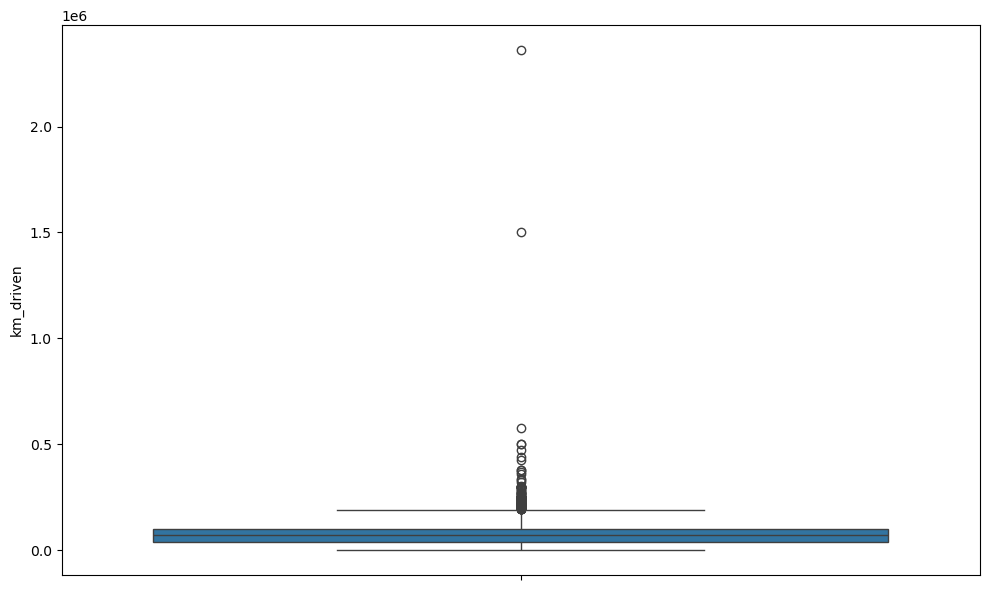

In [88]:
# проверим выбросы
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train_new_features["km_driven"], orient="v")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

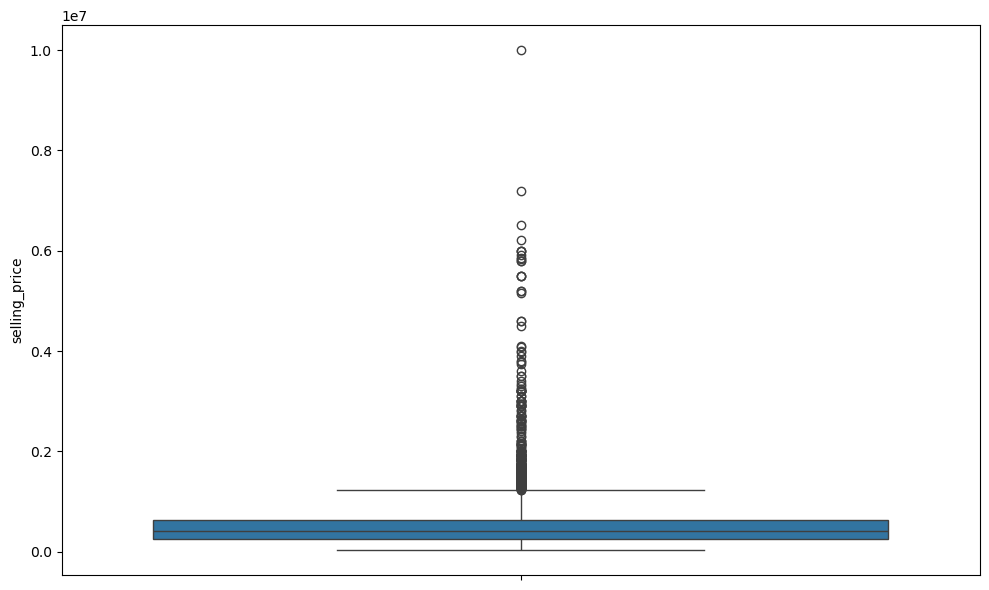

In [89]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train_new_features["selling_price"], orient="v")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<h4> мы видим, что в selling_price и km_driven у нас есть серьезные выбросы

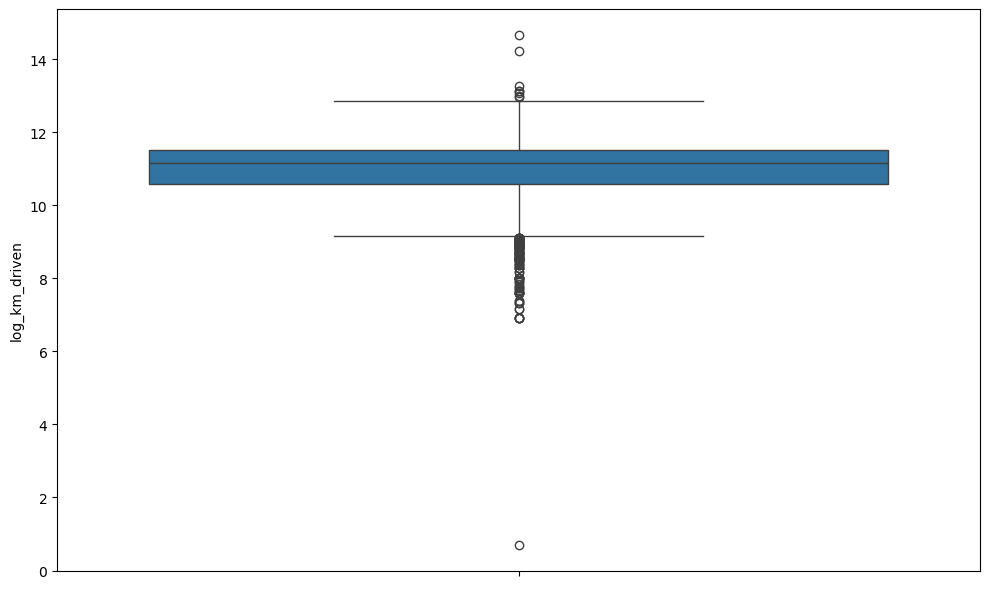

In [90]:
# попробую отлогарифмировать km_driven
df_train_new_features['log_km_driven'] = np.log1p(df_train_new_features['km_driven'])
df_test_new_features['log_km_driven'] = np.log1p(df_test_new_features['km_driven'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train_new_features['log_km_driven'], orient="v")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# результат стал действительно более сбалансированным


# сделать то же самое с selling_price мы не можем, так как это целевая переменная

In [91]:
# чтобы отследить пропуски, которые мы заполнили медианой, снова загрузим датасеты
df_train_skips = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test_skips = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

# при этом надо не забыть выкинуть дубликаты, чтобы сохранились индексы
df_train_skips = df_train_skips[~df_train_skips.drop(columns='selling_price').duplicated(keep='first')].reset_index()

train_skip_idx = df_train_skips[df_train_skips.isna().sum(axis=1) > 0].index
test_skip_idx = df_test_skips[df_test_skips.isna().sum(axis=1) > 0].index

In [92]:
df_train_new_features['skipped_flag'] = df_train_new_features.index.isin(train_skip_idx)
df_test_new_features['skipped_flag'] = df_test_new_features.index.isin(test_skip_idx)

<h3> Обучим модель на новых признаках

In [93]:
# для начала удалим ненужные признаки

df_train_new_features.drop(columns=['km_driven', 'name'], inplace=True) #вместо km_driven теперь log_km_driven
df_test_new_features.drop(columns=['km_driven', 'name'], inplace=True)

In [94]:
X_train = df_train_new_features.drop(columns='selling_price')
X_test = df_test_new_features.drop(columns='selling_price')
y_train = df_train_new_features['selling_price']
y_test = df_test_new_features['selling_price']

In [95]:
# проведем нормализацию параметров
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [96]:
ridge = Ridge(tol=0.0001, max_iter = 1000, alpha=100)

ridge.fit(X_train, y_train)
y_pred_new_ridge = ridge.predict(X_test)

In [97]:
print_metrics(y_test, y_pred_new_ridge)

print("\n\nВЕСА ПРИЗНАКОВ:")
for i in list(zip(ridge.coef_, df_train_new_features.drop(columns='selling_price').columns)):
    print(f"{i[1]:<30} = {float(i[0])}")

R2: 0.8826730422801402
MSE: 67442885643.55982
MAE: 128452.45361204859


ВЕСА ПРИЗНАКОВ:
year                           = 91723.21628400825
mileage                        = 3635.0388438677346
engine                         = -41973.65137895349
max_power                      = 114968.14235861573
torque                         = 11188.379834928572
seats                          = -5903.887713536209
max_torque_rpm                 = -26085.532822945406
fuel_Diesel                    = 554.1862823250962
fuel_LPG                       = 7604.247635158566
fuel_Petrol                    = 3804.9079852901395
seller_type_Individual         = -15413.711526898294
seller_type_Trustmark Dealer   = -4052.4055128656346
transmission_Manual            = -28737.54200551835
owner_Fourth & Above Owner     = -7889.846358455816
owner_Second Owner             = -17370.11664529069
owner_Test Drive Car           = 55553.24365645307
owner_Third Owner              = -11454.184879068329
enigne_over_power           

Результат получился просто отличный, учитывая, что наша целевая метрика - R2.
Мы прибавили целых 0.1 к метрике за счет добавления новых признаков. При правильном подобре модели результат может стать еще лучше.

# **Часть 5. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [x] Реализуйте метрику `business_metric`
- [x] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [98]:
def business_metrics(y_true, y_pred, threshold=0.1):
    return (np.abs(y_test - y_pred) / y_test < threshold).sum() / len(y_test)

print("Бизнес метрики на разных моделях:\n")
print(f"{'Ridge на новых признаках:':<30} {business_metrics(y_test, y_pred_new_ridge):>10.6f}")
print(f"{'Default LR:':<30} {business_metrics(y_test, y_pred_default):>10.6f}")
print(f"{'LR + scaled:':<30} {business_metrics(y_test, y_pred_scaled):>10.6f}")
print(f"{'Lasso:':<30} {business_metrics(y_test, y_pred_lasso):>10.6f}")
print(f"{'GridSearch Lasso:':<30} {business_metrics(y_test, y_pred_gs_lasso):>10.6f}")
print(f"{'GridSearch Elastic:':<30} {business_metrics(y_test, y_pred_gs_elastic):>10.6f}")
print(f"{'L0:':<30} {business_metrics(y_test, y_pred_l0):>10.6f}")
print(f"{'GridSearch Ridge:':<30} {business_metrics(y_test, y_pred_gs_ridge):>10.6f}")

# использовал чатгпт чтобы красивый print сделать

Бизнес метрики на разных моделях:

Ridge на новых признаках:        0.308000
Default LR:                      0.240000
LR + scaled:                     0.240000
Lasso:                           0.241000
GridSearch Lasso:                0.241000
GridSearch Elastic:              0.241000
L0:                              0.213000
GridSearch Ridge:                0.290000


Лучшую бизнес-метрику показывает именно Ridge на новых признаках.

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [x] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [x] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [99]:
# наша метрика будет сильнее штрафовать за недооценку, и слабее за переоценку
# коэффициенты штрафов можно задать в виде аргументов функции
# лучший результат в теории = 1, худший = -inf
def your_business_metrics(y_true, y_pred, penalty_over=3, penalty_under=1):
    error = 0
    for i in range(len(y_true)):
        diff = y_true[i] - y_pred[i]
        if diff > 0:
            error += penalty_under * diff
        else: 
            error += np.abs(penalty_over * diff)
    return 1 - error / np.sum(y_true)

In [100]:
print("Бизнес метрики на разных моделях:\n")
print(f"{'Ridge на новых признаках:':<30} {your_business_metrics(y_test, y_pred_new_ridge):>10.6f}")
print(f"{'Default LR:':<30} {your_business_metrics(y_test, y_pred_default):>10.6f}")
print(f"{'LR + scaled:':<30} {your_business_metrics(y_test, y_pred_scaled):>10.6f}")
print(f"{'Lasso:':<30} {your_business_metrics(y_test, y_pred_lasso):>10.6f}")
print(f"{'GridSearch Lasso:':<30} {your_business_metrics(y_test, y_pred_gs_lasso):>10.6f}")
print(f"{'GridSearch Elastic:':<30} {your_business_metrics(y_test, y_pred_gs_elastic):>10.6f}")
print(f"{'L0:':<30} {your_business_metrics(y_test, y_pred_l0):>10.6f}")
print(f"{'GridSearch Ridge:':<30} {your_business_metrics(y_test, y_pred_gs_ridge):>10.6f}")

# использовал чатгпт чтобы красивый print сделать

Бизнес метрики на разных моделях:

Ridge на новых признаках:        0.614498
Default LR:                      0.371287
LR + scaled:                     0.371287
Lasso:                           0.379939
GridSearch Lasso:                0.379939
GridSearch Elastic:              0.379939
L0:                              0.346496
GridSearch Ridge:                0.500046


Видно, что лучшую бизнес-метрику показывает также модель, обученная на новых признаках (Ridge)

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 25**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

<h3> Сохраню лучшую модель в pickle-file:

In [101]:
# в этой ячейке я собрал весь код, чтобы прийти от оригинального датасета к тому датасету, который мы загружаем в модель:

 
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

df_train = df_train[~df_train.drop(columns='selling_price').duplicated(keep='first')]
df_train = df_train.reset_index(drop=True)

train_skip_idx = df_train[df_train.isna().sum(axis=1) > 0].index
test_skip_idx = df_test[df_test.isna().sum(axis=1) > 0].index

df_train['skipped_flag'] = df_train.index.isin(train_skip_idx)
df_test['skipped_flag'] = df_test.index.isin(test_skip_idx)

def extract_number(series):
    return series.apply(
        lambda x: float(re.findall(regex_pattern, str(x))[0]) if pd.notnull(x) and re.findall(regex_pattern, str(x)) else np.nan
    )

for col in ['mileage', 'engine', 'max_power']:
    df_train[col] = extract_number(df_train[col])
    df_test[col]  = extract_number(df_test[col])

def extract_rpm(x):
    if pd.isna(x):
        return np.nan
    
    match = re.findall(r"(@|at|/)\s*[^0-9]*(?:[0-9,.]+-)?([0-9,.]*)", str(x), re.IGNORECASE)
    if not match:
        return np.nan
    match = float(str(match[0][1]).replace(',', ''))

    return match

df_train['max_torque_rpm'] = df_train['torque'].apply(extract_rpm)
df_test['max_torque_rpm'] = df_test['torque'].apply(extract_rpm)

def extract_torque(x):
    if pd.isna(x):
        return np.nan
    
    # регекс подобран методом проб и ошибок
    match = re.findall(r"([-+]?(?:\d*\.\d+|\d+))[^a-zA-Z]*(kgm|nm)?", str(x), re.IGNORECASE)[0]
    if not match:
        return np.nan

    unit = match[1].lower() if match[1] else None
    number = float(match[0]) * (1 if unit != 'kgm' else 9.8)

    return number

df_train['torque'] = df_train['torque'].apply(extract_torque)
df_test['torque'] = df_test['torque'].apply(extract_torque)


cols_with_na = [i[0] for i in filter(lambda x: x[1] > 0, dict(df_train.isna().sum()).items())]
for col in cols_with_na:
    train_median = df_train[col].median()
    df_train[col] = df_train[col].fillna(train_median)
    df_test[col] = df_test[col].fillna(train_median)


df_train['engine'] = df_train['engine'].apply(int)
df_train['seats'] = df_train['seats'].apply(int)
df_test['engine'] = df_test['engine'].apply(int)
df_test['seats'] = df_test['seats'].apply(int)

df_train['name'] = df_train['name'].apply(lambda x: ' '.join(x.split()[:2]))
df_test['name'] = df_test['name'].apply(lambda x: ' '.join(x.split()[:2]))

# добавим признак квадрата года выпуска автомобиля (корреляция была скорее квадратной, когда мы строили визуализации)
df_train['year'] = df_train['year'] ** 2
df_test['year'] = df_test['year'] ** 2

# добавим признак отношения числа лошадей на (мили)литр (милилитры - потому что у нас так записаны данные, не 1.6 литра, а 1600)
df_train['enigne_over_power'] = df_train['max_power'] / df_train['engine']
df_test['enigne_over_power'] = df_test['max_power'] / df_test['engine']

# добавим также признак потраченного за все время безнзина - это mileage * km_driven
df_train['fuel_spent'] = df_train['km_driven'] / 100 * df_train['mileage']
df_test['fuel_spent'] = df_test['km_driven'] / 100 * df_test['mileage']


# добавим признак ср. цены по марке и модели автомобиля
means = df_train.groupby('name')['selling_price'].mean()
df_train['model_avg_price'] = df_train['name'].map(means)
df_test['model_avg_price']  = df_test['name'].map(means).fillna(df_train['selling_price'].mean())

# добавим признак страны производства
def get_country(name):
    # P.S. воспользовался chatgpt для того, чтобы сформировать этот словарь
    manufacturer_country = {
    "Maruti": "India",
    "Skoda": "Czech Republic",
    "Hyundai": "South Korea",
    "Toyota": "Japan",
    "Ford": "USA",
    "Renault": "France",
    "Mahindra": "India",
    "Honda": "Japan",
    "Chevrolet": "USA",
    "Fiat": "Italy",
    "Datsun": "Japan",
    "Tata": "India",
    "Jeep": "USA",
    "Mercedes-Benz": "Germany",
    "Mitsubishi": "Japan",
    "Audi": "Germany",
    "Volkswagen": "Germany",
    "BMW": "Germany",
    "Nissan": "Japan",
    "Lexus": "Japan",
    "Jaguar": "United Kingdom",
    "Land": "United Kingdom",
    "MG": "United Kingdom",
    "Volvo": "Sweden",
    "Daewoo": "South Korea",
    "Kia": "South Korea",
    "Force": "India",
    "Ambassador": "India",
    "Isuzu": "Japan",
    "Peugeot": "France",
    "Opel": "Germany",
    "Ashok": "India"
}
    return manufacturer_country[name.split()[0]]

df_train['country'] = df_train['name'].apply(lambda x: get_country(x))
df_test['country'] = df_test['name'].apply(lambda x: get_country(x))

def add_ohe_features(train_df, test_df, columns):
    ohc = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

    for col in columns:
        ohc.fit(train_df[[col]])

        train_encoded = ohc.transform(train_df[[col]])
        train_df[ohc.get_feature_names_out([col])] = train_encoded

        test_encoded = ohc.transform(test_df[[col]])
        test_df[ohc.get_feature_names_out([col])] = test_encoded

    return train_df, test_df

df_train, df_test = add_ohe_features(
    df_train, 
    df_test, 
    columns=['fuel', 'seller_type', 'transmission', 'owner', 'country']
)
df_train = df_train.drop(columns=['fuel', 'seller_type', 'transmission', 'owner', 'country'])
df_test = df_test.drop(columns=['fuel', 'seller_type', 'transmission', 'owner', 'country'])

df_train['log_km_driven'] = np.log1p(df_train['km_driven'])
df_test['log_km_driven'] = np.log1p(df_test['km_driven'])
df_train.drop(columns=['km_driven', 'name'], inplace=True)
df_test.drop(columns=['km_driven', 'name'], inplace=True)

df_train_copy = df_train.copy(deep=True)
df_test_copy = df_test.copy(deep=True)

X_train = df_train.drop(columns='selling_price')
X_test = df_test.drop(columns='selling_price')
y_train = df_train['selling_price']
y_test = df_test['selling_price']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ridge = Ridge(tol=0.0001, max_iter = 1000, alpha=100)

ridge.fit(X_train, y_train)

Ridge(alpha=100, max_iter=1000)

<h3> Напишем класс трансформера, который делает все те преобразования, которые есть в верхней ячейки (кроме scaler)

In [102]:
# я закинул весь код из ячейки выше в чатгпт, чтобы он помог мне сделать трансформер (потому что мы это еще не изучали)
# в итоге все равно пришлось делать его самому, но с опорой на чатгпт (скорее теоретическая опора, весь класс написан ПОЛНОСТЬЮ вручную)
class MyTransormer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.regex_pattern = r"[-+]?([0-9]*\.[0-9]+|\d+)"

    def fit(self, X_real, y_real):
        X = X_real.copy(deep=True)
        y = y_real.copy(deep=True)
        y = y[~X.duplicated(keep='first')]
        X = X[~X.duplicated(keep='first')]
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        for col in ['mileage', 'engine', 'max_power']:
            X[col]  = self.extract_number(X[col])
        X['max_torque_rpm'] = X['torque'].apply(self.extract_rpm)
        X['torque'] = X['torque'].apply(self.extract_torque)

        self.cols_with_na = [i[0] for i in filter(lambda x: x[1] > 0, dict(X.isna().sum()).items())]
        self.train_medians = {}
        for col in self.cols_with_na:
            self.train_medians[col] = X[col].median()
            X[col] = X[col].fillna(self.train_medians[col])

        X['engine'] = X['engine'].apply(int)
        X['seats'] = X['seats'].apply(int)
        X['name'] = X['name'].apply(lambda x: ' '.join(x.split()[:2]))
        X['year'] = X['year'] ** 2
        X['enigne_over_power'] = X['max_power'] / X['engine']
        X['fuel_spent'] = X['km_driven'] / 100 * X['mileage']
        X_y = pd.concat([X, pd.DataFrame(y, columns=['selling_price'])], axis=1)
        self.means = X_y.groupby('name')['selling_price'].mean()
        self.train_mean_y = np.mean(y)
        X['model_avg_price']  = X['name'].map(self.means).fillna(self.train_mean_y)
        X['country'] = X['name'].apply(lambda x: self.get_country(x))

        self.cat_columns = ['fuel', 'seller_type', 'transmission', 'owner', 'country']
        self.ohc_cols = {}
        for col in self.cat_columns: 
            ohc = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
            ohc.fit(X[[col]])
            self.ohc_cols[col] = ohc
        self.raw_feature_names_ = X_real.columns.tolist()
        self.cat_columns_unique = {i: X[i].unique() for i in ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']}
        # self.num_columns = []
        # print(X.columns)
        return self

    def transform(self, X_real):
        X = X_real.copy(deep=True)
        skip_idx = X[X.isna().sum(axis=1) > 0].index
        X['skipped_flag'] = X.index.isin(skip_idx)
        for col in ['mileage', 'engine', 'max_power']:
            X[col]  = self.extract_number(X[col])
        X['max_torque_rpm'] = X['torque'].apply(self.extract_rpm)
        X['torque'] = X['torque'].apply(self.extract_torque)
        for col in self.cols_with_na:
            X[col] = X[col].fillna(self.train_medians[col])
        X['engine'] = X['engine'].apply(int)
        X['seats'] = X['seats'].apply(int)
        X['name'] = X['name'].apply(lambda x: ' '.join(x.split()[:2]))
        X['year'] = X['year'] ** 2
        X['enigne_over_power'] = X['max_power'] / X['engine']
        X['fuel_spent'] = X['km_driven'] / 100 * X['mileage']
        X['model_avg_price']  = X['name'].map(self.means).fillna(self.train_mean_y)
        X['country'] = X['name'].apply(lambda x: self.get_country(x))
        X = self.add_ohe_features(X)
        X = X.drop(columns=self.cat_columns)
        X['log_km_driven'] = np.log1p(X['km_driven'])
        X.drop(columns=['km_driven', 'name'], inplace=True)
        self.feature_names_ = X.columns.tolist()
        return X
    
    def extract_number(self, series):
            return series.apply(
                lambda x: float(re.findall(self.regex_pattern, str(x))[0]) if pd.notnull(x) and re.findall(self.regex_pattern, str(x)) else np.nan
            )
    def extract_rpm(self, x):
        if pd.isna(x):
            return np.nan
        
        match = re.findall(r"(@|at|/)\s*[^0-9]*(?:[0-9,.]+-)?([0-9,.]*)", str(x), re.IGNORECASE)
        if not match:
            return np.nan
        match = float(str(match[0][1]).replace(',', ''))

        return match

    def extract_torque(self, x):
        if pd.isna(x):
            return np.nan
        # регекс подобран методом проб и ошибок
        match = re.findall(r"([-+]?(?:\d*\.\d+|\d+))[^a-zA-Z]*(kgm|nm)?", str(x), re.IGNORECASE)[0]
        if not match:
            return np.nan

        unit = match[1].lower() if match[1] else None
        number = float(match[0]) * (1 if unit != 'kgm' else 9.8)
        return number

    def get_country(self, name):
        # P.S. воспользовался chatgpt для того, чтобы сформировать этот словарь
        manufacturer_country = {
        "Maruti": "India",
        "Skoda": "Czech Republic",
        "Hyundai": "South Korea",
        "Toyota": "Japan",
        "Ford": "USA",
        "Renault": "France",
        "Mahindra": "India",
        "Honda": "Japan",
        "Chevrolet": "USA",
        "Fiat": "Italy",
        "Datsun": "Japan",
        "Tata": "India",
        "Jeep": "USA",
        "Mercedes-Benz": "Germany",
        "Mitsubishi": "Japan",
        "Audi": "Germany",
        "Volkswagen": "Germany",
        "BMW": "Germany",
        "Nissan": "Japan",
        "Lexus": "Japan",
        "Jaguar": "United Kingdom",
        "Land": "United Kingdom",
        "MG": "United Kingdom",
        "Volvo": "Sweden",
        "Daewoo": "South Korea",
        "Kia": "South Korea",
        "Force": "India",
        "Ambassador": "India",
        "Isuzu": "Japan",
        "Peugeot": "France",
        "Opel": "Germany",
        "Ashok": "India"
    }
        return manufacturer_country[name.split()[0]]
    
    def add_ohe_features(self, X):
        for col in self.cat_columns:
            ohc = self.ohc_cols[col]
            X_encoded = ohc.transform(X[[col]])
            X[ohc.get_feature_names_out([col])] = X_encoded
        return X

In [103]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')
X_train = df_train.drop(columns='selling_price')
y_train = df_train['selling_price']
X_test = df_test.drop(columns='selling_price')
y_test = df_test['selling_price']

In [104]:
trans = MyTransormer()
trans.fit(X_train, y_train)
hz = trans.transform(X_test)

In [105]:
# mismatching_cols = []
# for col in df_test_copy.drop(columns='selling_price').columns:
#     if np.sum(df_test_copy[col] == hz[col]) < len(hz[col]):
#         mismatching_cols.append(col)
# print(mismatching_cols) 
# # тут будут, колонки, которые не совпадают после моей обработки трансформером и оригинальной обработкой в ноутбуке
# # у нас этот список пустой, что очень хорошо

<h3> Теперь объединим все в один Pipeline

In [106]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')
X_train = df_train.drop(columns='selling_price')
y_train = df_train['selling_price']
X_test = df_test.drop(columns='selling_price')
y_test = df_test['selling_price']

In [107]:
pipe = Pipeline([
    ('transformer', MyTransormer()),
    ('scaler' , StandardScaler()),
    ('model', Ridge(tol=0.0001, max_iter = 1000, alpha=100))
])

pipe.fit(X_train.copy(), y_train.copy())
y_pred_pipeline = pipe.predict(X_test.copy())
y_pred_pipeline_train = pipe.predict(X_train.copy())

In [108]:
print_metrics(y_test, y_pred_pipeline)
# метрики такие же, как и в ноутбуке

R2: 0.8869457591638247
MSE: 64986805968.659515
MAE: 127521.59103679073


Итог: наш пайплайн дает точно такой же реузльтат, как и полная обработка в ноутбуке, поэтому сохраним его в качестве модели.

In [109]:
with open("models/ridge_new_features.pkl", "wb") as f:
    pickle.dump(pipe, f)

In [110]:
with open("models/ridge_new_features.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print_metrics(y_test, loaded_model.predict(X_test))

# все работает!!!

R2: 0.8869457591638247
MSE: 64986805968.659515
MAE: 127521.59103679073


#